# Imports

In [13]:
import os
from copy import copy

import itertools
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.utils.data as data
import torch.distributions as dist
import torch.optim as optim
import torch.utils.data
from tqdm import tqdm
from torchvision import transforms
from npyx.c4.dataset_init import N_CHANNELS, WAVEFORM_SAMPLES, LABELLING, CORRESPONDENCE, calc_snr
from npyx.c4.dl_utils import generate_kl_weight, define_forward_vae
from pathlib import Path
import matplotlib.pyplot as plt
from npyx.ml import set_seed
import npyx

%matplotlib inline
%config InlineBackend.figure_format = 'retina'
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [14]:
home = str(Path.home())
DATA_PATH = f"{home}/Desktop/C4_data_23_04_17/23_04_17_hausser.h5"
# LISBERGER_DATA_PATH = f"{home}/Desktop/lisberger_neurons_2022_10_24.h5"
PATH = os.path.dirname(os.path.abspath(""))
DEVICE = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
DIR = os.getcwd()
SEED = 1234
USE_CUDA = torch.cuda.is_available()
BETA = 5
MONKEY_WAVEFORM_SAMPLES = int(WAVEFORM_SAMPLES * 40_000 / 30_000)

set_seed(SEED)
torch.set_default_dtype(torch.float32)

Random seed 1234 has been set.


# Data 

Here we specify in which directory the `.h5` datasets are located, and read the hausser, hull and hull unlabelled datasets.
Note that the hull labelled dataset is read every time by default but the labelled neurons will be discarded later.

In [15]:
DATASETS_DIRECTORY = "/home/npyx/Desktop/C4_data_final_23_07_26/"

In [16]:
dataset_paths = npyx.c4.get_paths_from_dir(DATASETS_DIRECTORY, include_hull_unlab=True)

# Normalise waveforms so that the max in the dataset is 1 and the minimum is -1. Only care about shape.
BASE_DATASET = npyx.c4.extract_and_merge_datasets(
    *dataset_paths,
    quality_check=False,
    normalise_wvf=False,  # Will be normalised later anyway!
    _use_amplitudes=False,
    n_channels=N_CHANNELS,
    central_range=WAVEFORM_SAMPLES,
    labelled=False,
)

Loading dataset /home/npyx/Desktop/C4_data_final_23_07_26/C4_database_hull_labelled.h5


Reading dataset:   0%|          | 0/103 [00:00<?, ?it/s]

0 unlabelled and 103 labelled neurons loaded. 
0 neurons discarded, of which labelled: 0. More details at the 'discarded_df' attribute. 

Loading dataset /home/npyx/Desktop/C4_data_final_23_07_26/C4_database_hull_unlabelled.h5


Reading dataset:   0%|          | 0/1425 [00:00<?, ?it/s]

1425 unlabelled and 0 labelled neurons loaded. 
0 neurons discarded, of which labelled: 0. More details at the 'discarded_df' attribute. 

Loading dataset /home/npyx/Desktop/C4_data_final_23_07_26/C4_database_hausser.h5


Reading dataset:   0%|          | 0/1998 [00:00<?, ?it/s]

1885 unlabelled and 113 labelled neurons loaded. 
0 neurons discarded, of which labelled: 0. More details at the 'discarded_df' attribute. 



We make the dataset unlabelled, as we do not want the labelled data to be seen at this step.

In [17]:
BASE_DATASET.make_unlabelled_only()
BASE_DATASET.make_full_dataset(wf_only=True)

Now let's extract the waveforms that will be used to train the VAEs by using the `preprocess_template` function

In [18]:
relevant_list = []

for wave in tqdm(BASE_DATASET.wf):
    waveform_2d = wave.reshape(N_CHANNELS, -1)
    for wf in waveform_2d:
        if calc_snr(wf, return_db=True) <= 25:
            continue

        scaled_wvf = npyx.datasets.preprocess_template(wf, clip_size=[1e-3, 2e-3])
        if np.max(np.abs(scaled_wvf[40:])) > 1:
            continue
        relevant_list.append(scaled_wvf)
print(
    f"Extracted a total of {len(relevant_list)} waveforms out of {len(BASE_DATASET)*N_CHANNELS} ({len(relevant_list)/(len(BASE_DATASET)*N_CHANNELS)*100:.2f}%)"
)

100%|██████████| 3310/3310 [00:06<00:00, 482.69it/s]

Extracted a total of 19495 waveforms out of 33100 (58.90%)


In [19]:
# This constant will be needed later when computing the ELBO loss (as a scaling factor)
DATASET_LEN = len(relevant_list)

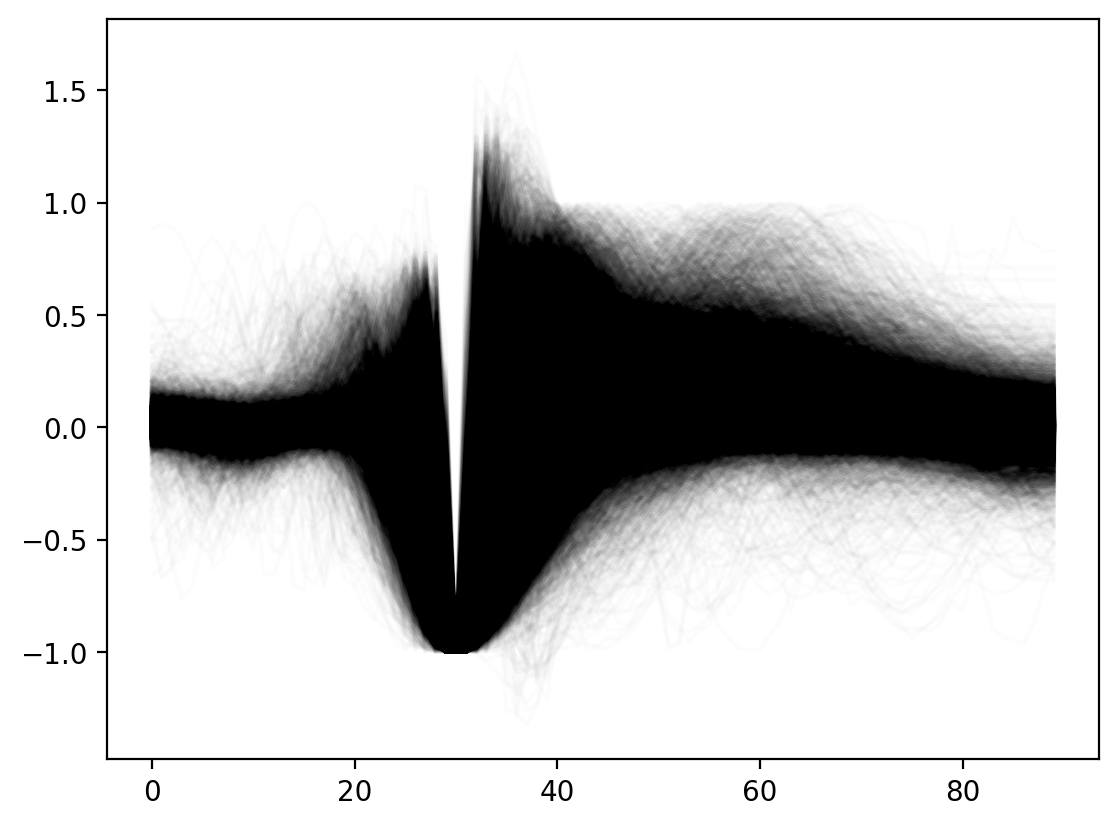

In [20]:
for wf in relevant_list:
    plt.plot(wf, alpha=0.01, color="k")
plt.show()

## Dataloaders and augmentations

Next we create a "horizontal compression" data augmentation which is going to add more variety to the waveform widths the network sees.

We also create a PyTorch `data.Dataset` class which is going to work with the DataLoader during training to get batches of data.

In [21]:
class HorizontalCompression(object):
    """Compress or expand the signal horizontally by a given factor."""

    def __init__(self, p=0.3, max_compression_factor=0.6):
        self.max_compression_factor = max_compression_factor
        self.p = p

    def __call__(self, sample):
        if self.p <= np.random.rand():
            return sample
        wvf = np.squeeze(sample).reshape(1, -1)

        used_factor = np.random.choice(
            np.linspace(0.1, self.max_compression_factor, 5), size=1
        )

        factor = 1 + used_factor if np.random.choice([0, 1]) == 1 else 1 - used_factor

        new_wvf_shape = (1, int(np.ceil(wvf.shape[1] / factor)))
        new_wvf = np.zeros(new_wvf_shape)
        new_wvf[0] = np.interp(
            np.arange(0, wvf.shape[1], factor), np.arange(wvf.shape[1]), wvf[0]
        )
        if new_wvf.shape[1] != int(WAVEFORM_SAMPLES * 3 / 4):
            diff = new_wvf.shape[1] - int(WAVEFORM_SAMPLES * 3 / 4)
            if diff > 0:  # Crop
                crop_left = diff // 2
                crop_right = diff - crop_left
                new_wvf = new_wvf[:, crop_left:-crop_right]
            else:  # Pad
                pad_left = -diff // 2
                pad_right = -diff - pad_left
                new_wvf = np.pad(
                    new_wvf, ((0, 0), (pad_left, pad_right)), mode="reflect"
                )
        new_wvf = new_wvf.ravel().reshape(1, -1).copy().astype(np.float32)

        return new_wvf

In [22]:
class CerebellumWFDataset(data.Dataset):
    """Dataset of waveforms as images. Every batch will have shape:
    (batch_size, 1, N_CHANNELS, WAVEFORM_SAMPLES)"""

    def __init__(self, data, labels, transforms=None):
        """
        Args:
            data (ndarray): Array of data points
            labels (string): Array of labels for the provided data
        """
        self.data = data
        self.labels = labels
        self.transforms = transforms

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        if torch.is_tensor(idx):
            idx = idx.tolist()
        data_point = (
            self.data[idx, :]
            .astype("float32")
            .reshape(1, int(WAVEFORM_SAMPLES * 3 / 4))
        )
        label = self.labels[idx].astype("int")

        if self.transforms:
            data_point = self.transforms(data_point)

        return data_point, label

# Training

## Custom Loss

For training, we define a custom MSE loss that will penalise more errors made at the centre of the waveform (depolarisation and repolarisation), and use it inside the ELBO loss for our VAE

In [23]:
class CustomMSELoss(nn.Module):
    def __init__(self, weight_factor=2.0):
        super(CustomMSELoss, self).__init__()
        self.weight_factor = weight_factor
        self.mse_loss = nn.MSELoss(reduction="none")

    def forward(self, input, target):
        # Compute the MSE loss for the entire image without reduction
        mse_loss = self.mse_loss(input, target)

        # Define the weight mask to assign higher weight to specific region
        weight_mask = torch.ones_like(target)
        weight_mask[:, :, 20:40] *= self.weight_factor

        return mse_loss * weight_mask

In [24]:
def ELBO_VAE(enc, dec, X, beta=1, n_samples=10):
    """

    INPUT:
    enc : Instance of `Encoder` class, which returns a distribution
          over Z when called on a batch of inputs X
    dec : Instance of `Decoder` class, which returns a distribution
          over X when called on a batch of inputs Z
    X   : A batch of datapoints, torch.FloatTensor of shape = (batch_size, 1, 10, 60).

    """

    batch_size = X.shape[0]
    ELBO = torch.zeros(batch_size).to(DEVICE)
    for _ in range(n_samples):
        q_z = enc.forward(X)  # q(Z | X)
        z = (
            q_z.rsample()
        )  # Samples from the encoder posterior q(Z | X) using the reparameterization trick

        reconstruction = dec.forward(z)  # distribution p(x | z)

        prior = dist.Normal(
            torch.zeros_like(q_z.loc).to(DEVICE), torch.ones_like(q_z.scale).to(DEVICE)
        )

        custom_mse = CustomMSELoss(weight_factor=1.0)

        MSE = custom_mse(reconstruction, X).sum(dim=(1, 2))

        KLD = dist.kl_divergence(q_z, prior).sum(dim=1)

        ELBO += MSE + beta * (batch_size / DATASET_LEN) * KLD

    return (ELBO / n_samples).mean()

## Parameters definition

In [25]:
train_params = {
    "beta": BETA,
    "d_latent": 10,
    "dropout_l0": 0.1,
    "dropout_l1": 0.1,
    "lr": 1e-4,
    "n_layers": 2,
    "n_units_l0": 600,
    "n_units_l1": 300,
    "optimizer": "Adam",
    "batch_size": 128,
}

## Initialising objects

In [26]:
set_seed(SEED)
torch.cuda.empty_cache()

enc, dec = define_forward_vae(len(relevant_list[0]), params=train_params, device=DEVICE)

BATCH_SIZE = train_params["batch_size"]
# Add augmentation transforms if wanted
labels = np.array([0] * DATASET_LEN)
wf_dataset = np.stack(relevant_list)

# Add augmentation transforms if wanted
cerebellum_dataset = CerebellumWFDataset(
    wf_dataset,
    labels,
    transforms=transforms.Compose([HorizontalCompression()]),
)
train_loader = data.DataLoader(cerebellum_dataset, batch_size=BATCH_SIZE, shuffle=True)

optimizer_name = train_params["optimizer"]
lr = train_params["lr"]
optim_args = {
    "params": itertools.chain(enc.parameters(), dec.parameters()),
    "lr": lr,
}
opt_vae = getattr(optim, optimizer_name)(**optim_args)

Random seed 1234 has been set.


## Training loop

In [27]:
scheduler = torch.optim.lr_scheduler.CosineAnnealingWarmRestarts(
    opt_vae, 20, 1, last_epoch=-1
)

N_epochs = 60
losses = []

kl_weights = generate_kl_weight(N_epochs, beta=train_params["beta"])


for epoch in tqdm(range(N_epochs), desc="Epochs"):
    train_loss = 0.0
    for X, _ in train_loader:
        X = X.to(DEVICE)
        opt_vae.zero_grad()
        loss = ELBO_VAE(enc, dec, X, beta=kl_weights[epoch])
        loss.backward()
        opt_vae.step()
        train_loss += loss.item() * X.shape[0] / len(BASE_DATASET)
    scheduler.step()
    losses.append(train_loss)

enc.eval()
dec.eval()

Epochs:   0%|          | 0/60 [00:00<?, ?it/s]

Epochs: 100%|██████████| 60/60 [05:18<00:00,  5.31s/it]


Decoder(
  (decoder): Sequential(
    (0): Linear(in_features=10, out_features=300, bias=True)
    (1): GELU(approximate='none')
    (2): Dropout(p=0.1, inplace=False)
    (3): Linear(in_features=300, out_features=600, bias=True)
    (4): GELU(approximate='none')
    (5): Dropout(p=0.1, inplace=False)
    (6): Linear(in_features=600, out_features=90, bias=True)
  )
)

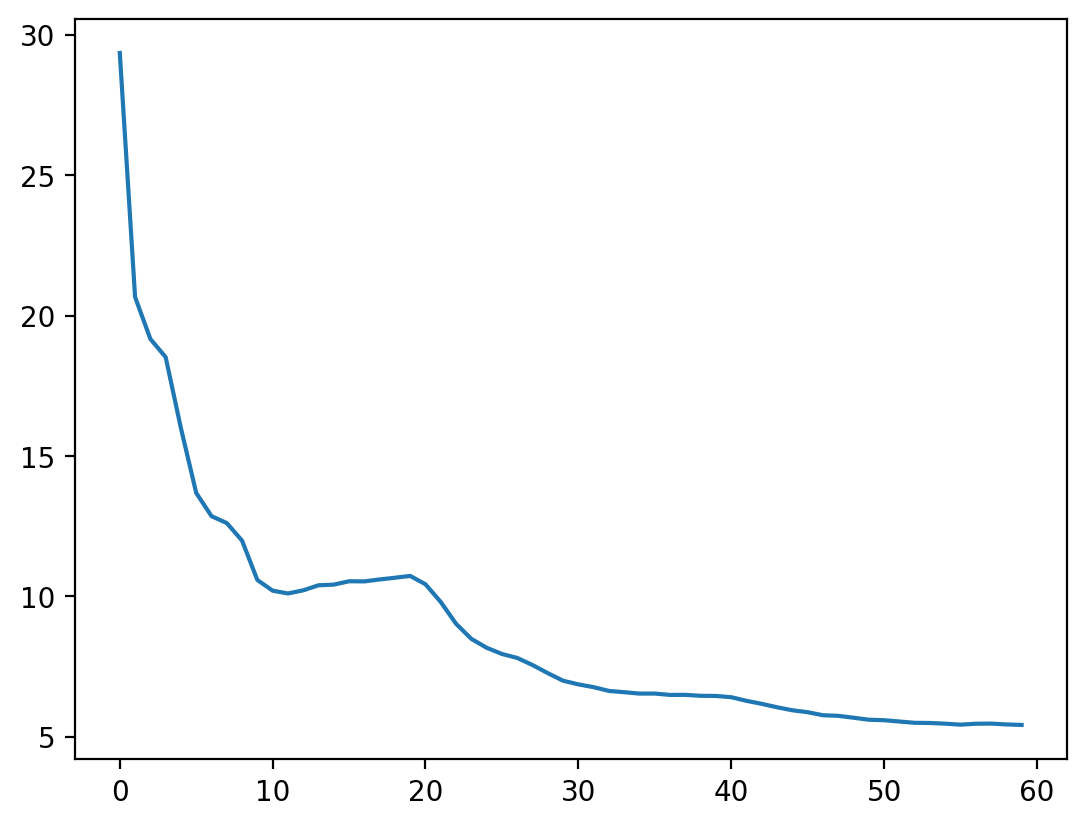

In [28]:
plt.plot(losses)

In [29]:
raise ValueError("Stop here")

ValueError: Stop here

## Save model run

In [38]:
enc = enc.eval().cpu()
dec = dec.eval().cpu()

In [39]:
torch.save(
    enc.state_dict(),
    os.path.join(
        Path.home(), ".npyx_c4_resources", "vaes", "wvf_singlechannel_encoder.pt"
    ),
)
torch.save(
    dec.state_dict(),
    os.path.join(
        Path.home(), ".npyx_c4_resources", "vaes", "wvf_singlechannel_decoder.pt"
    ),
)

---

# Inspection

In [31]:
def plot_random_reconstruction(full_dataset, enc, dec, n_neurons=1, label=None):
    """
    Plots a random neuron from the dataset. Optionally, can specify a label
    """
    if label is not None:
        if label in CORRESPONDENCE:
            mask = full_dataset[:, 0] == label
            full_dataset = full_dataset[mask, :]
        elif label in LABELLING:
            mask = full_dataset[:, 0] == LABELLING[label]
            full_dataset = full_dataset[mask, :]
        else:
            return "Invalid label"

    if n_neurons > full_dataset.shape[0]:
        print(f"Only {full_dataset.shape[0]} neurons to plot.")
        n_neurons = full_dataset.shape[0]

    idx = np.random.choice(range(full_dataset.shape[0]), n_neurons, replace=False)
    for i in idx:
        fig, axs = plt.subplots(1, 2, figsize=(12, 6), constrained_layout=True)
        wf_original = full_dataset[i, :].reshape(int(WAVEFORM_SAMPLES * 3 / 4))

        axs[0].plot(wf_original)
        axs[0].set_title("Original Peak channel waveform")

        with torch.no_grad():
            network_input = torch.Tensor(
                full_dataset[i, :]
                .reshape(1, 1, int(WAVEFORM_SAMPLES * 3 / 4))
                .astype(np.float32)
            )
            wf_reconstructed = (
                dec(enc(network_input).mean)
                .reshape(int(WAVEFORM_SAMPLES * 3 / 4))
                .detach()
                .numpy()
            )

        axs[1].plot(wf_reconstructed)
        axs[1].set_title("Reconstructed Peak channel waveform")

        plt.show()

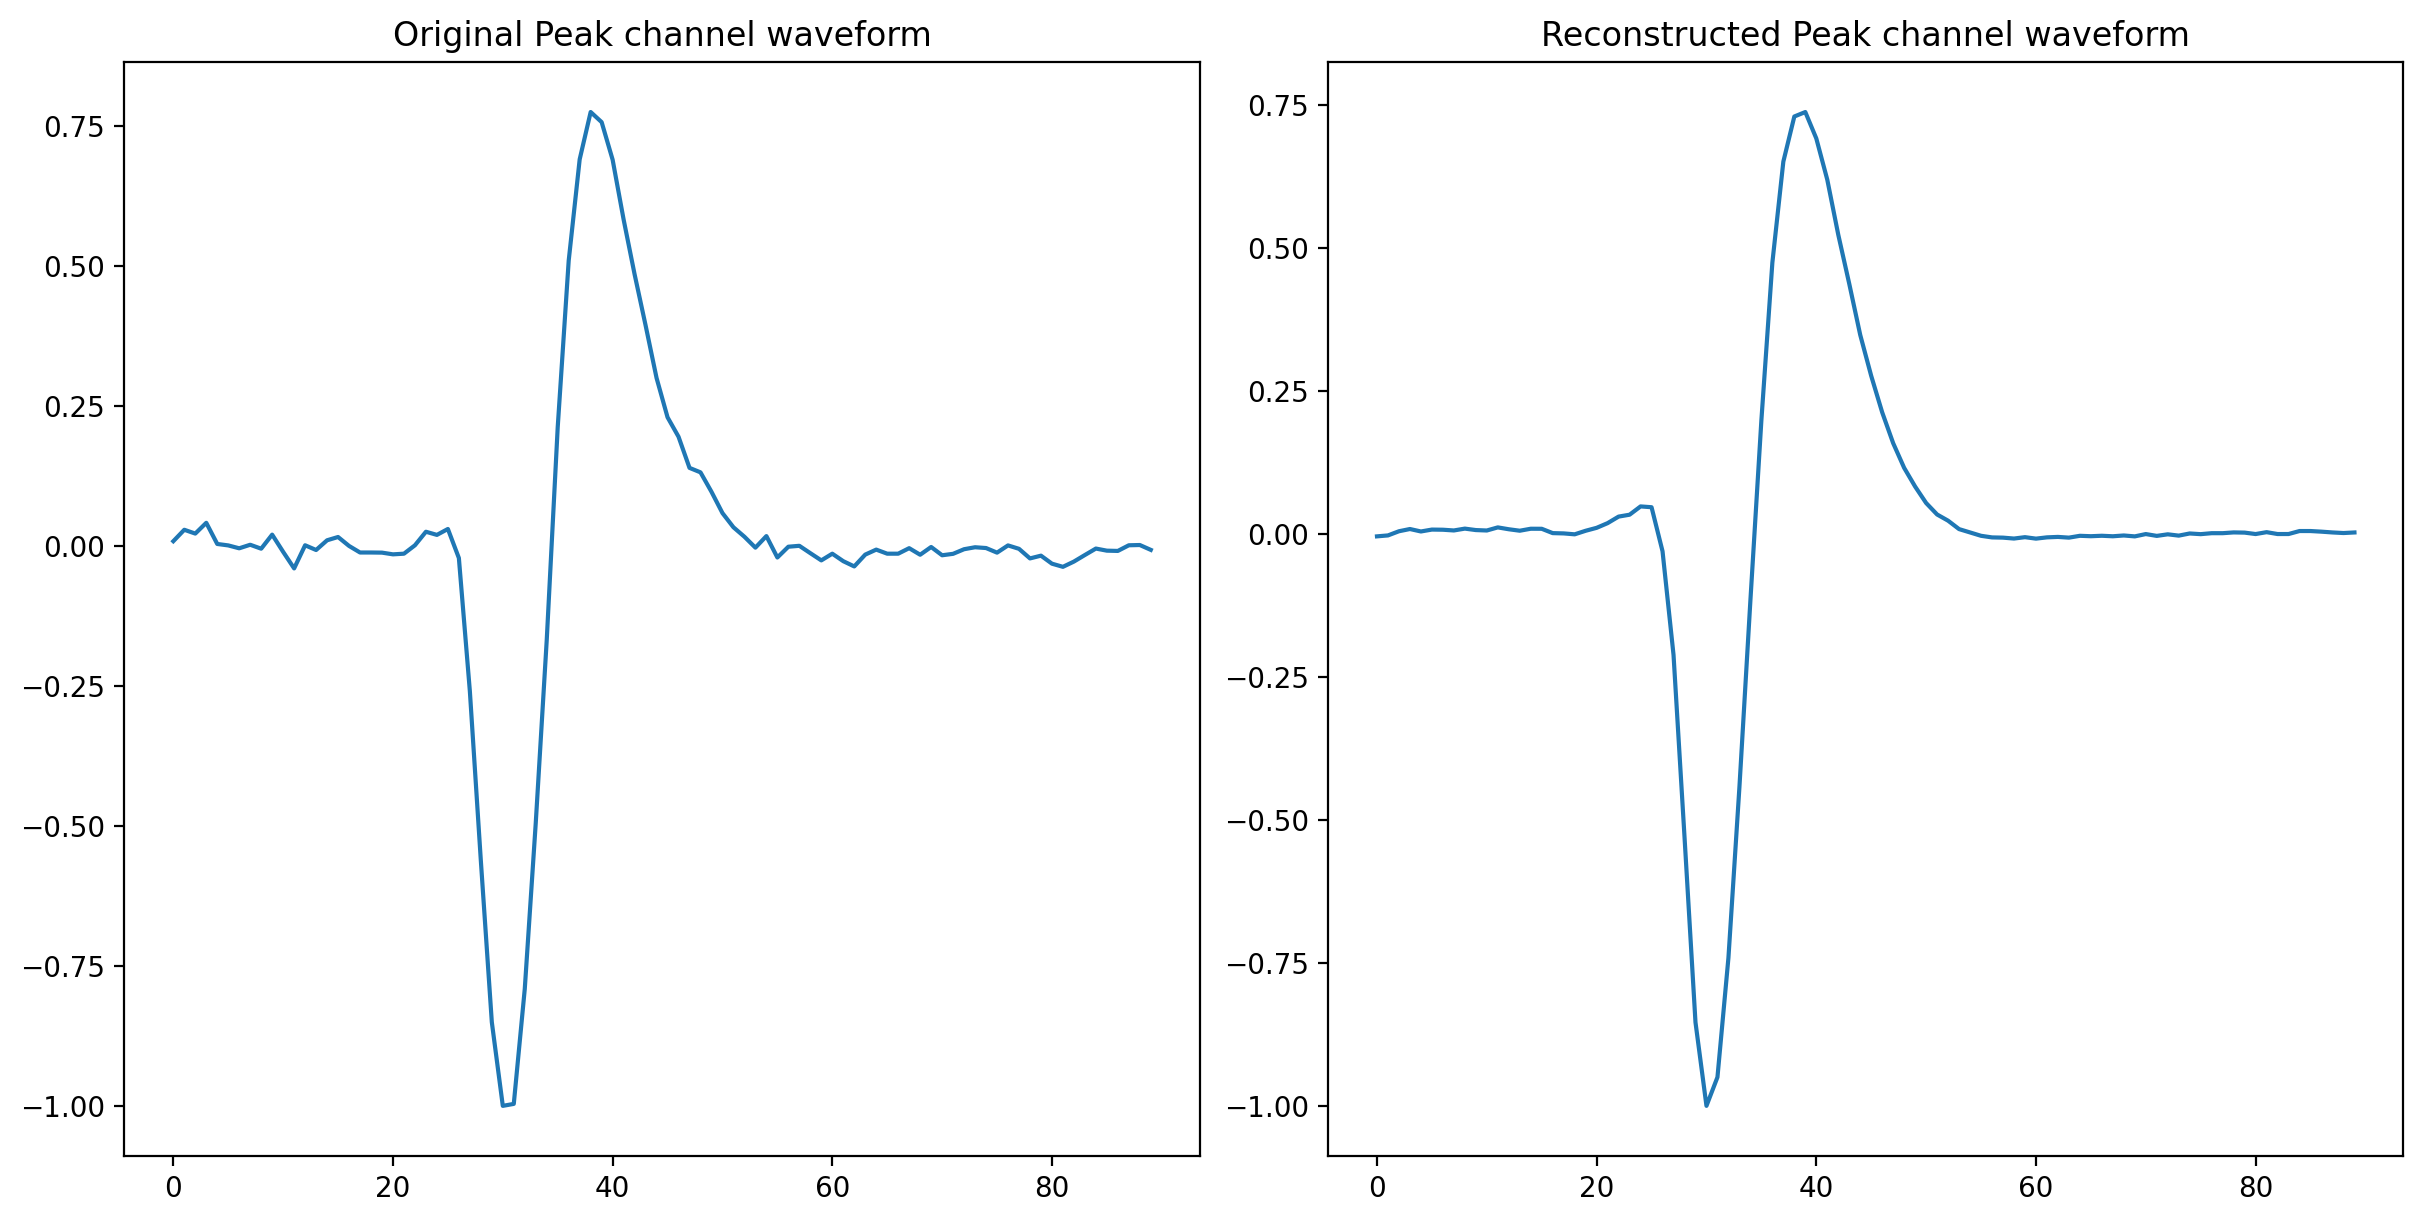

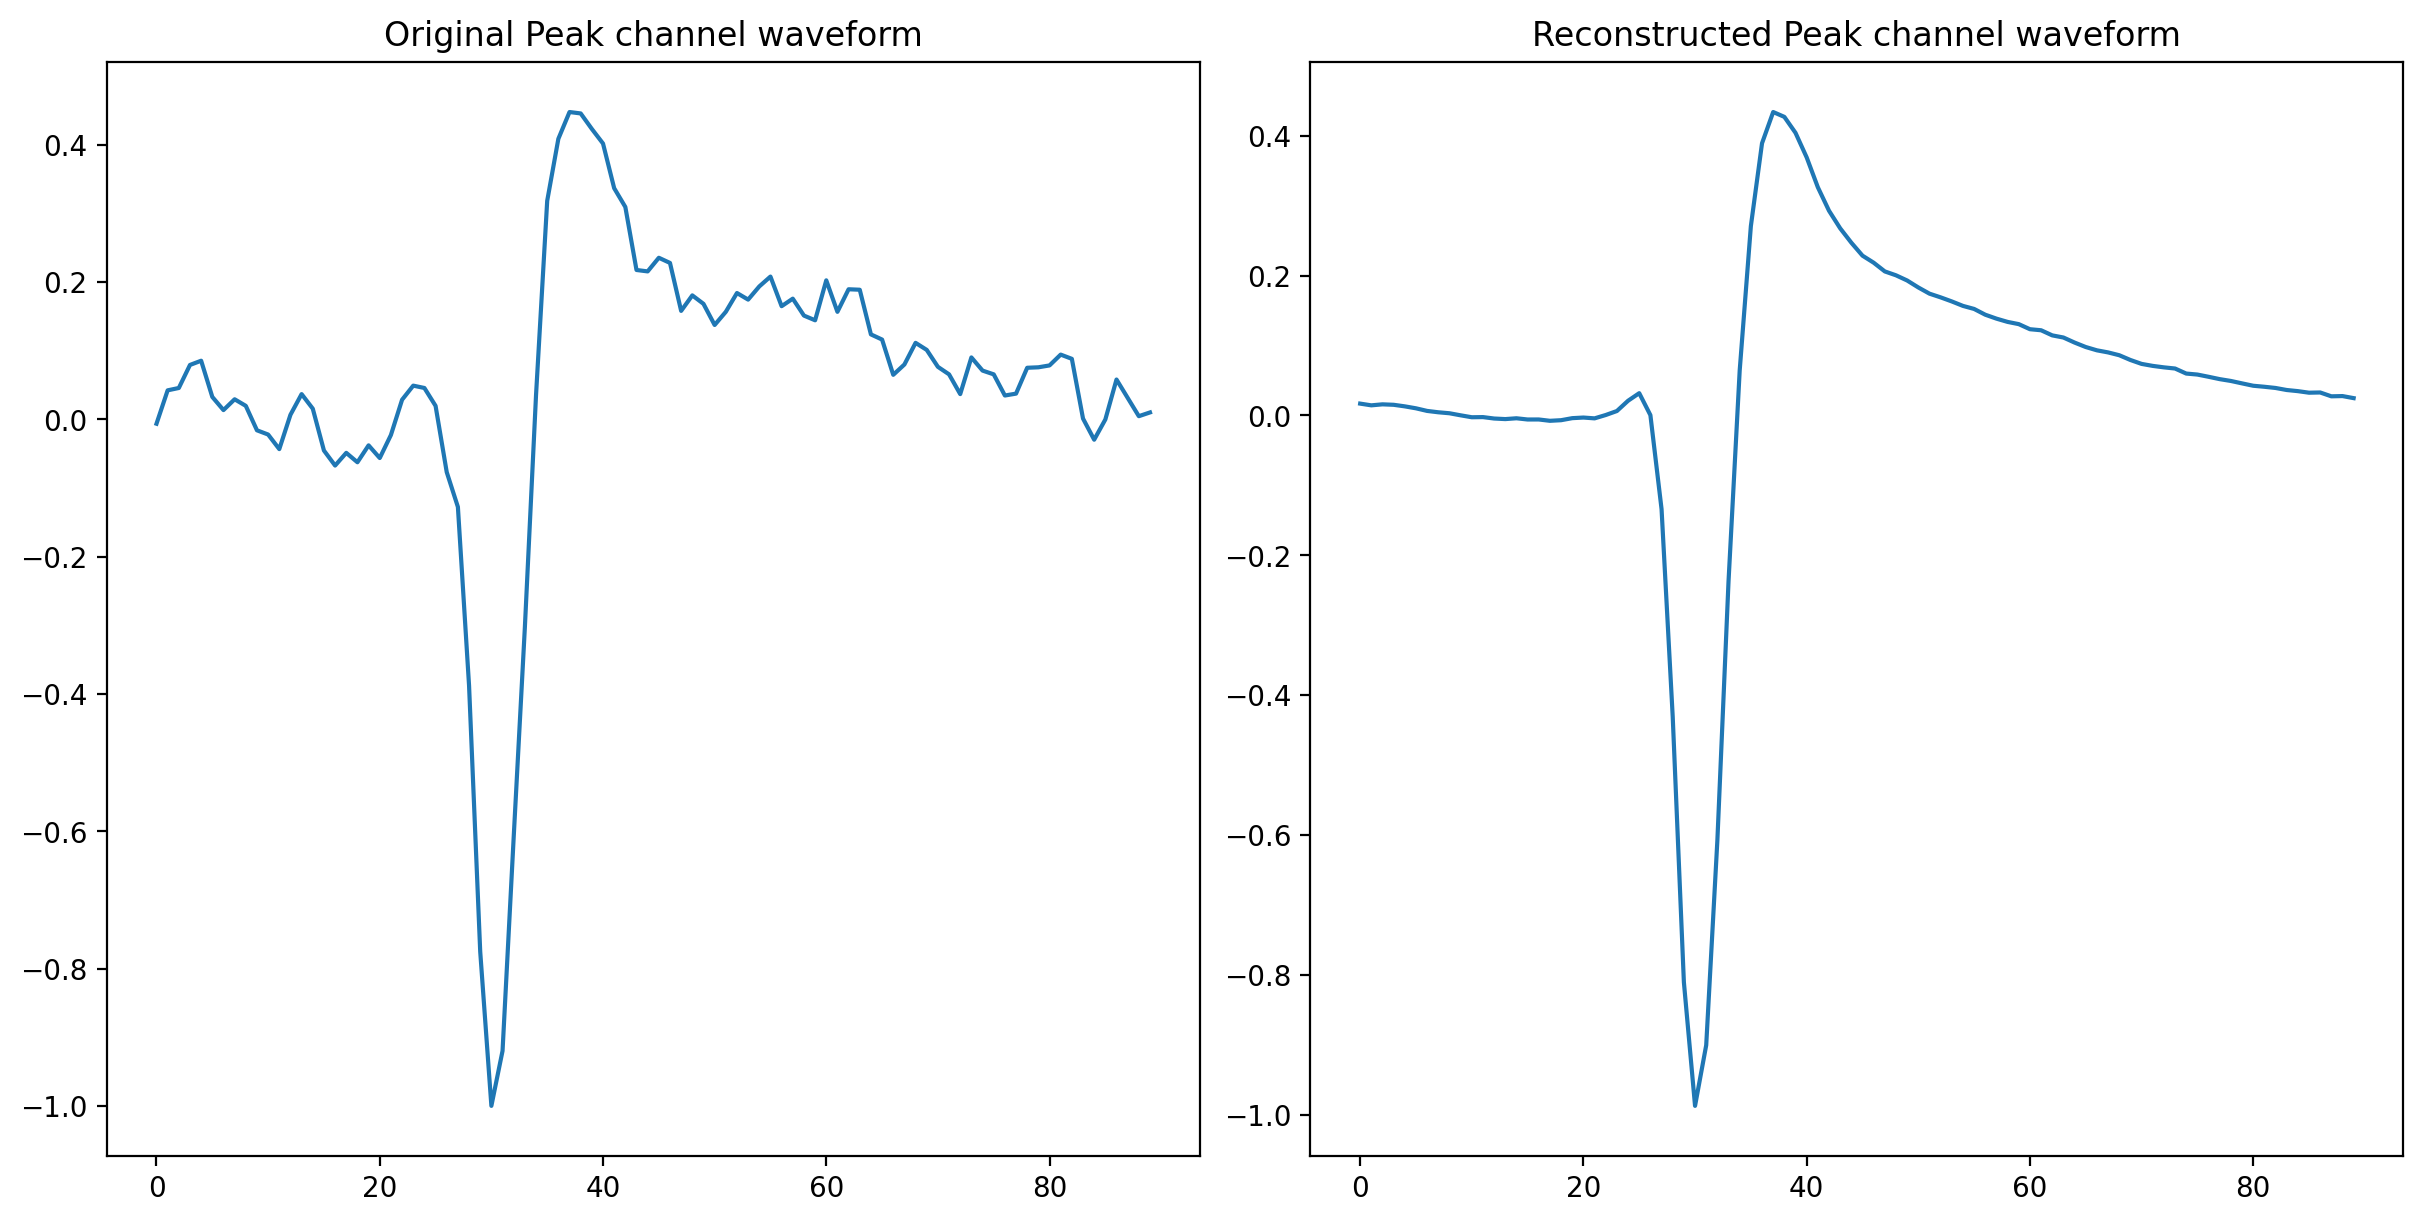

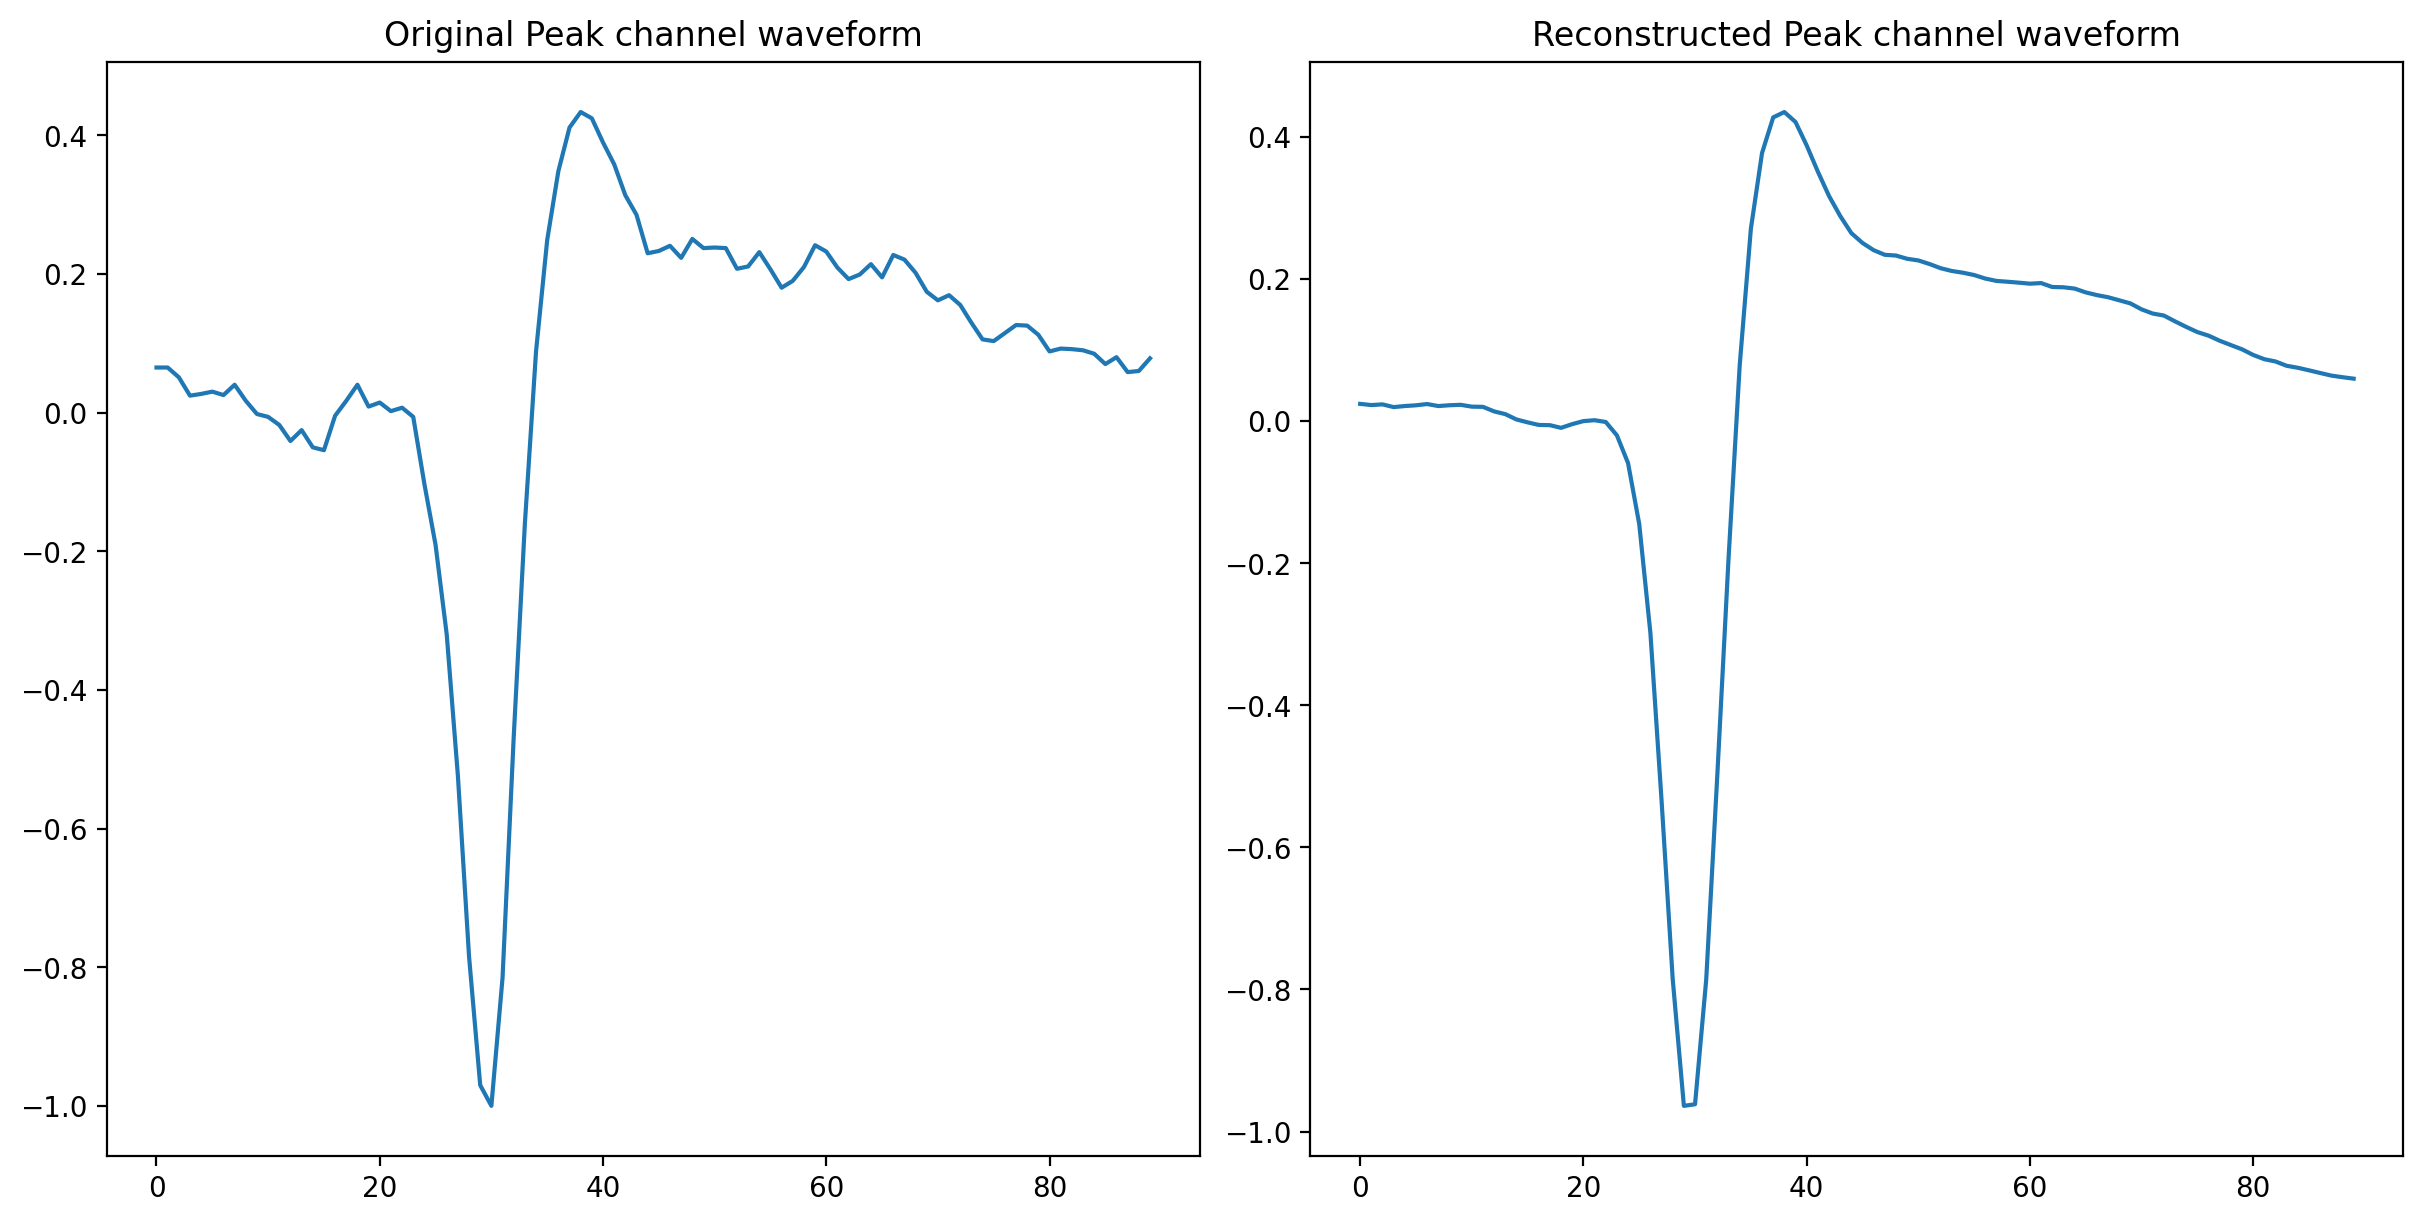

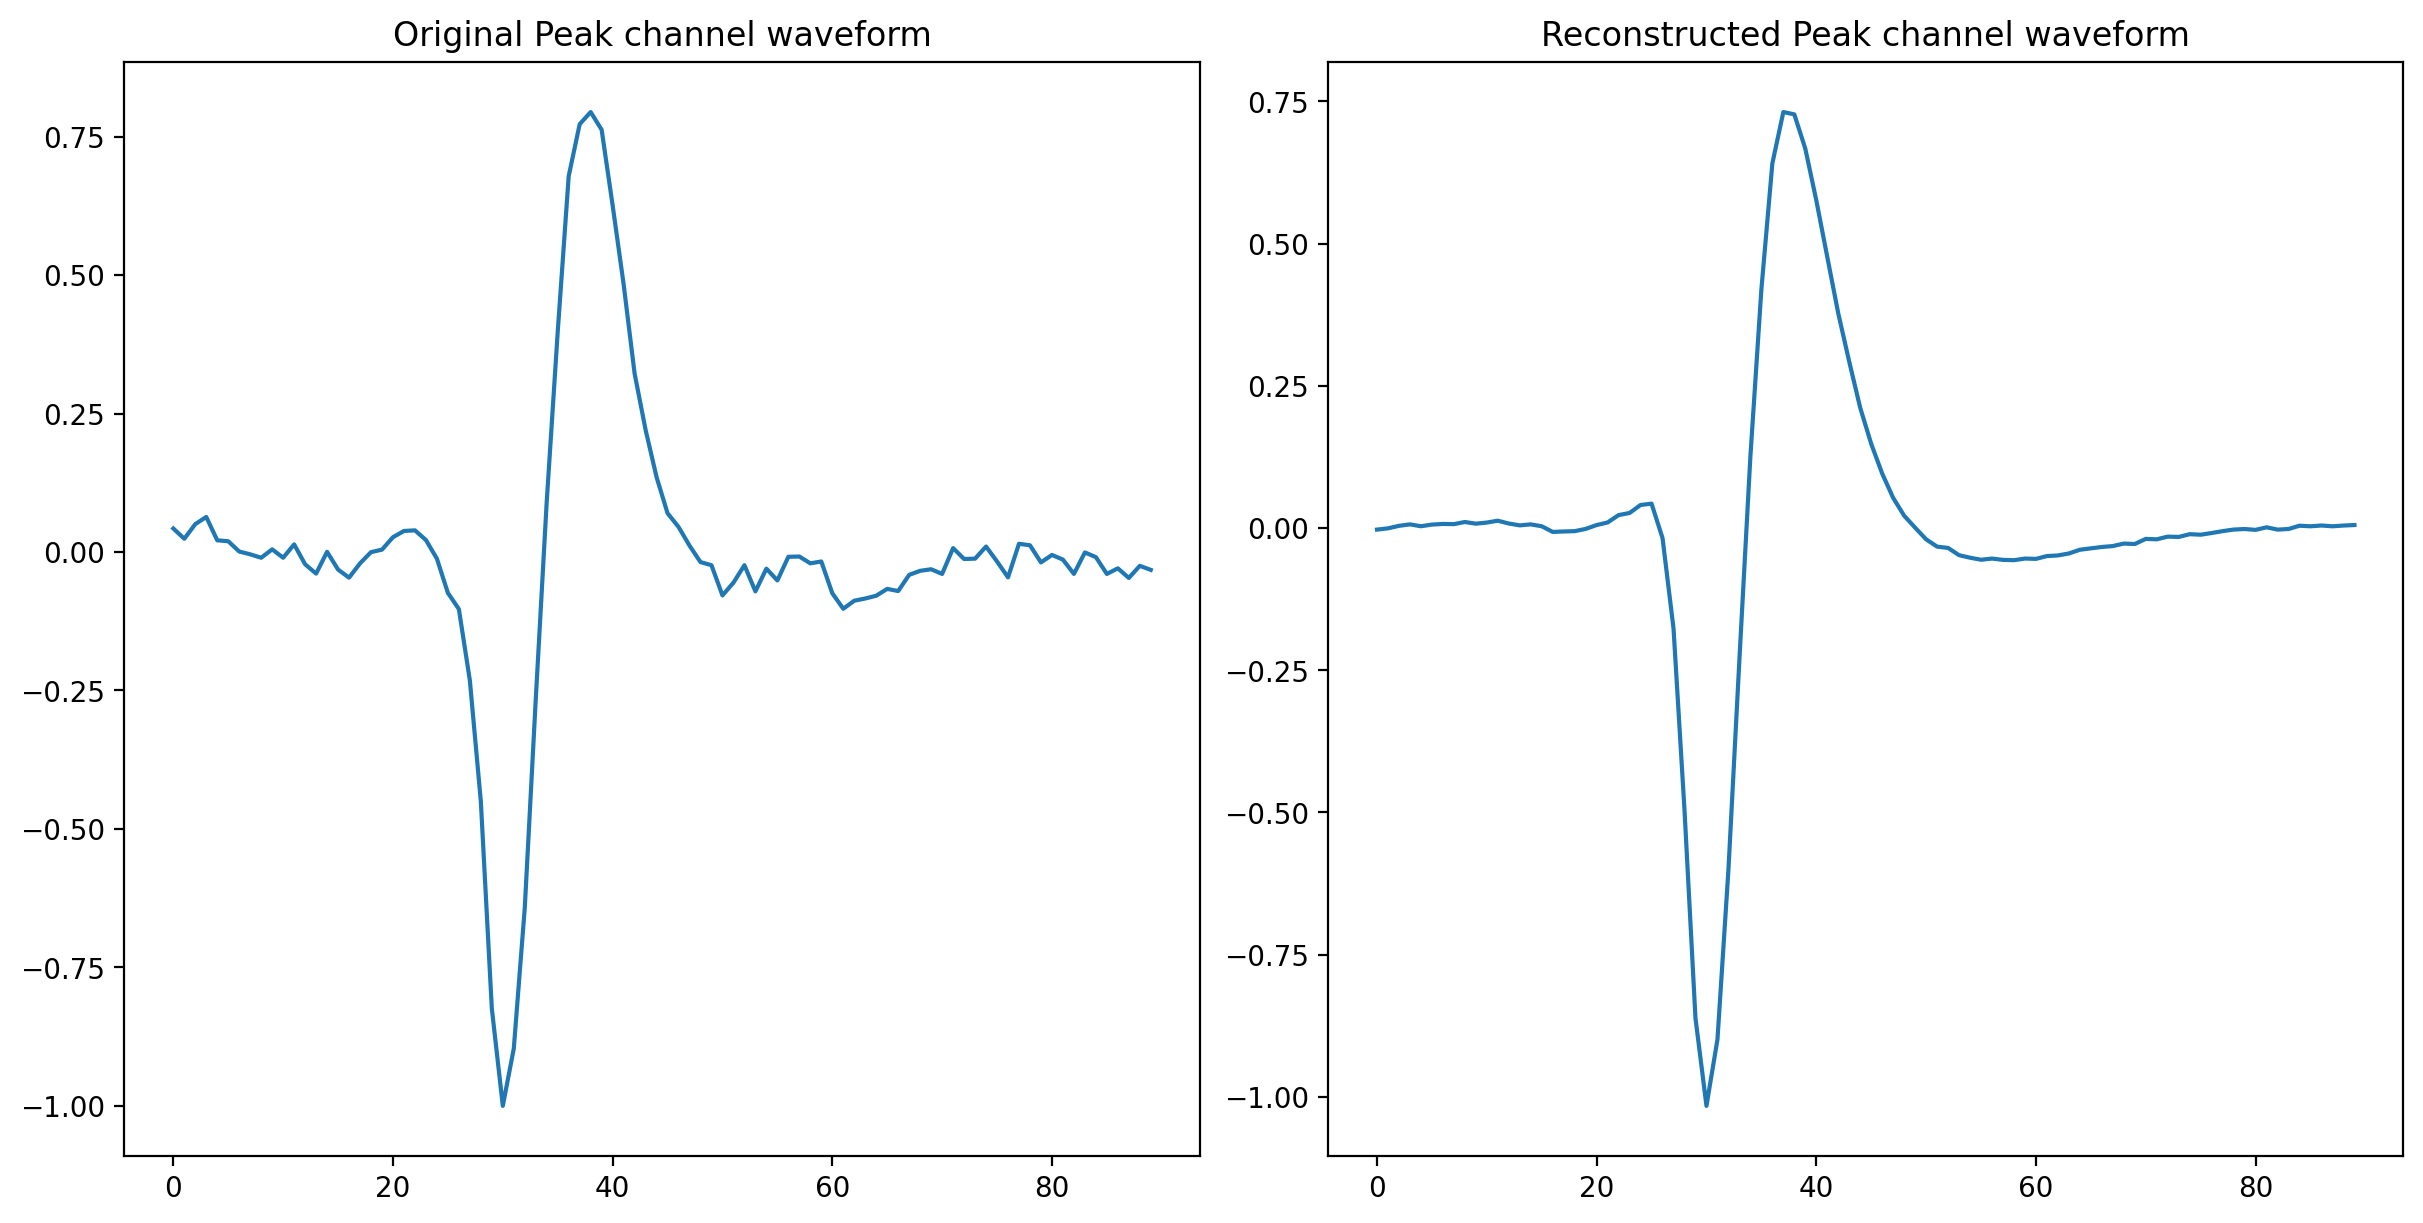

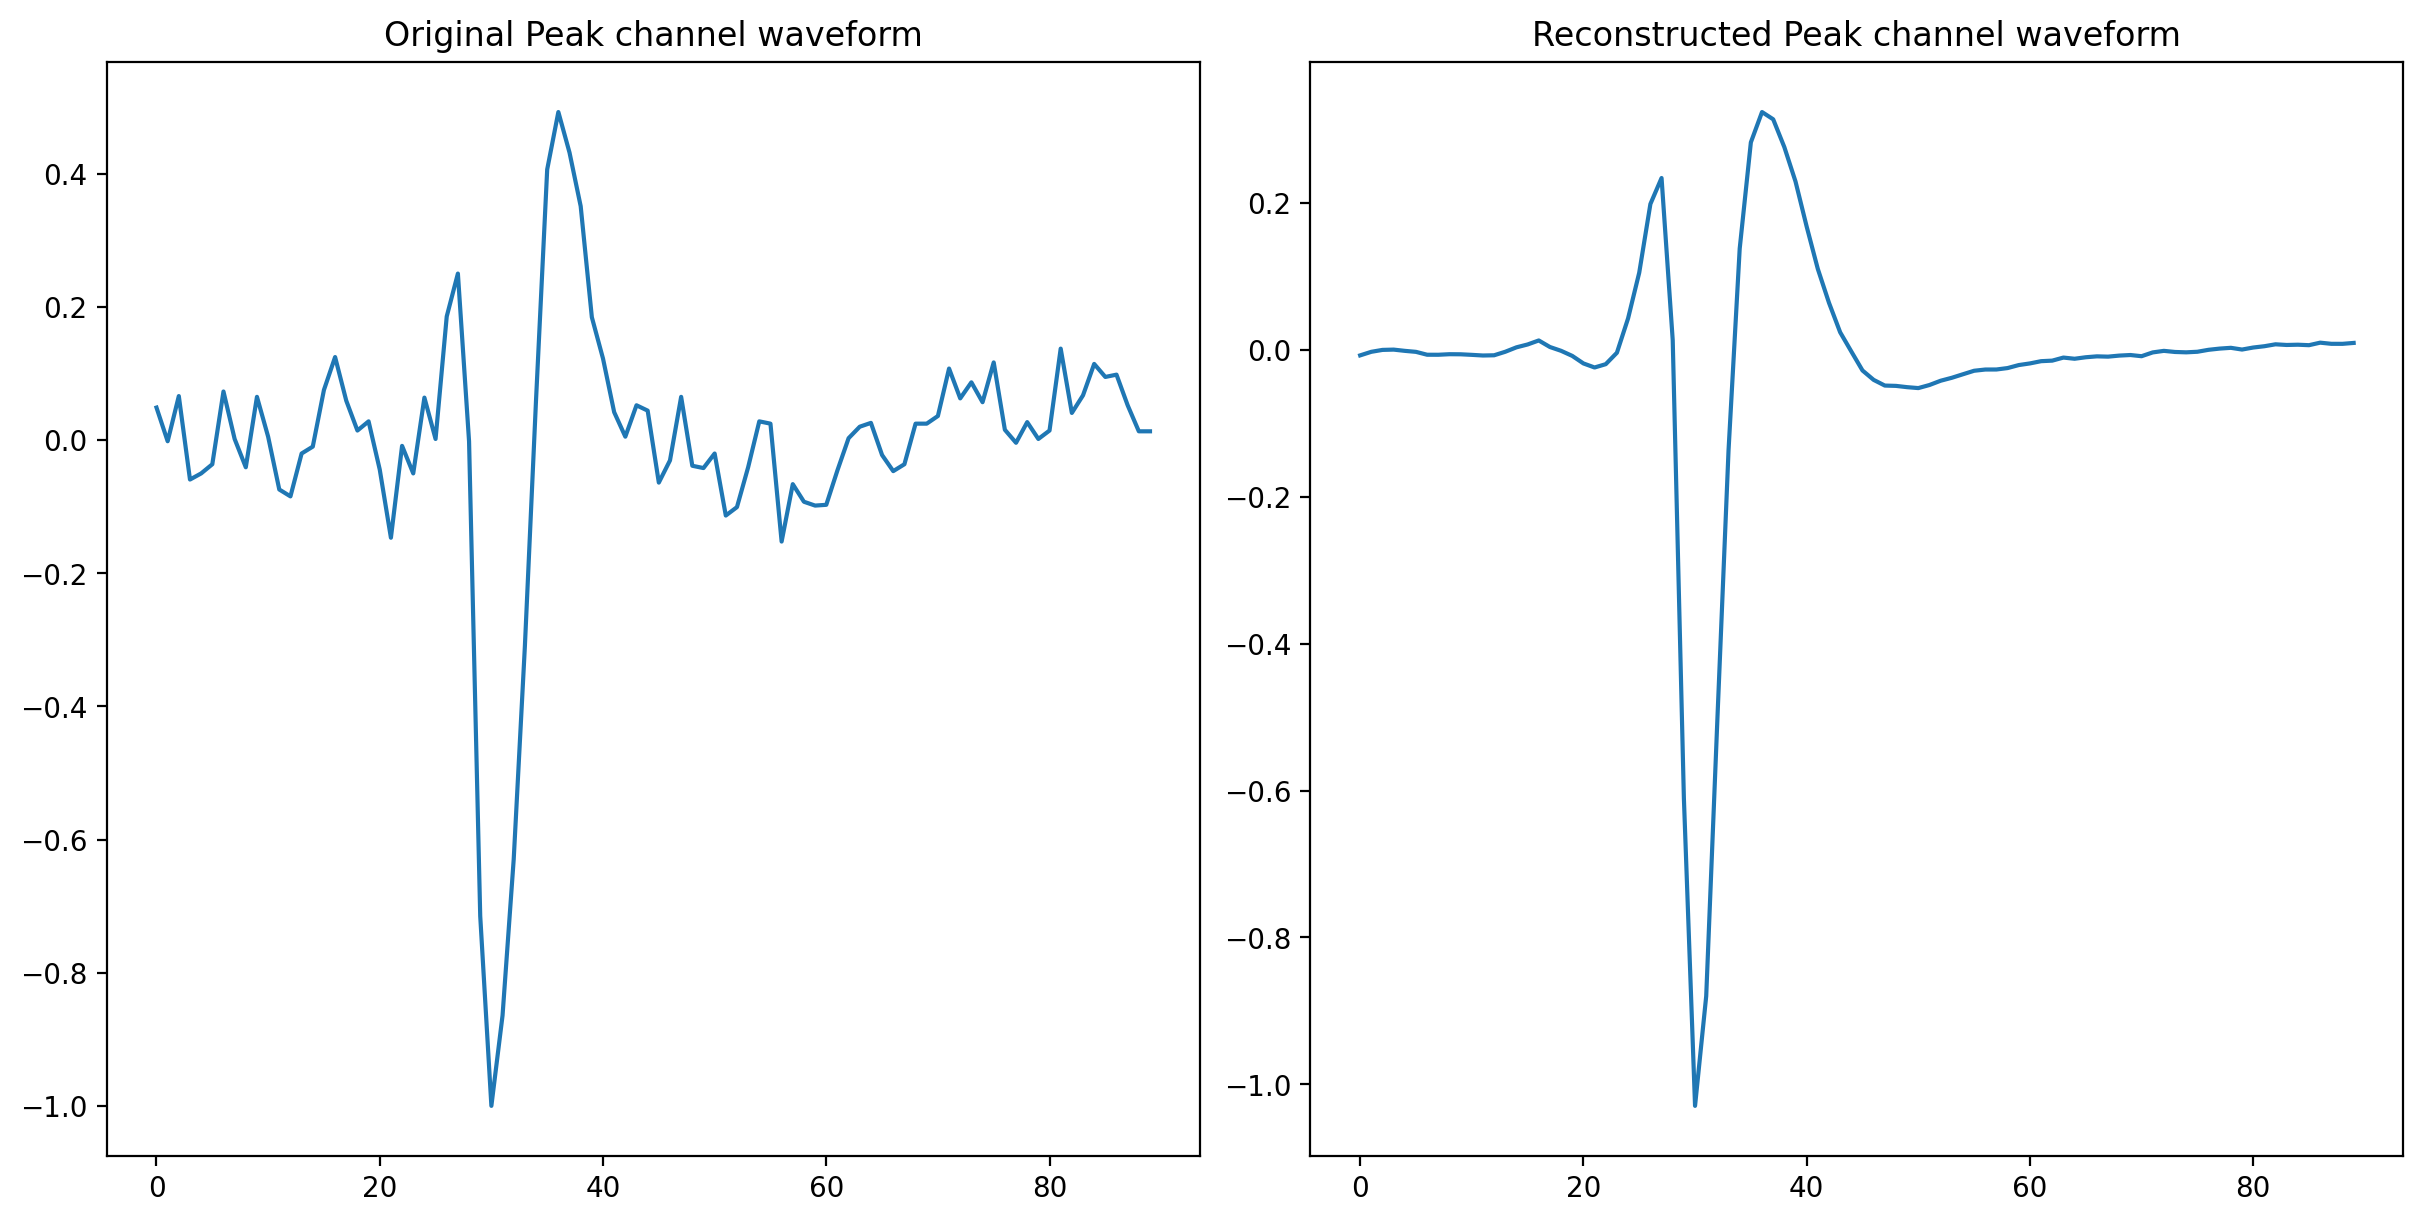

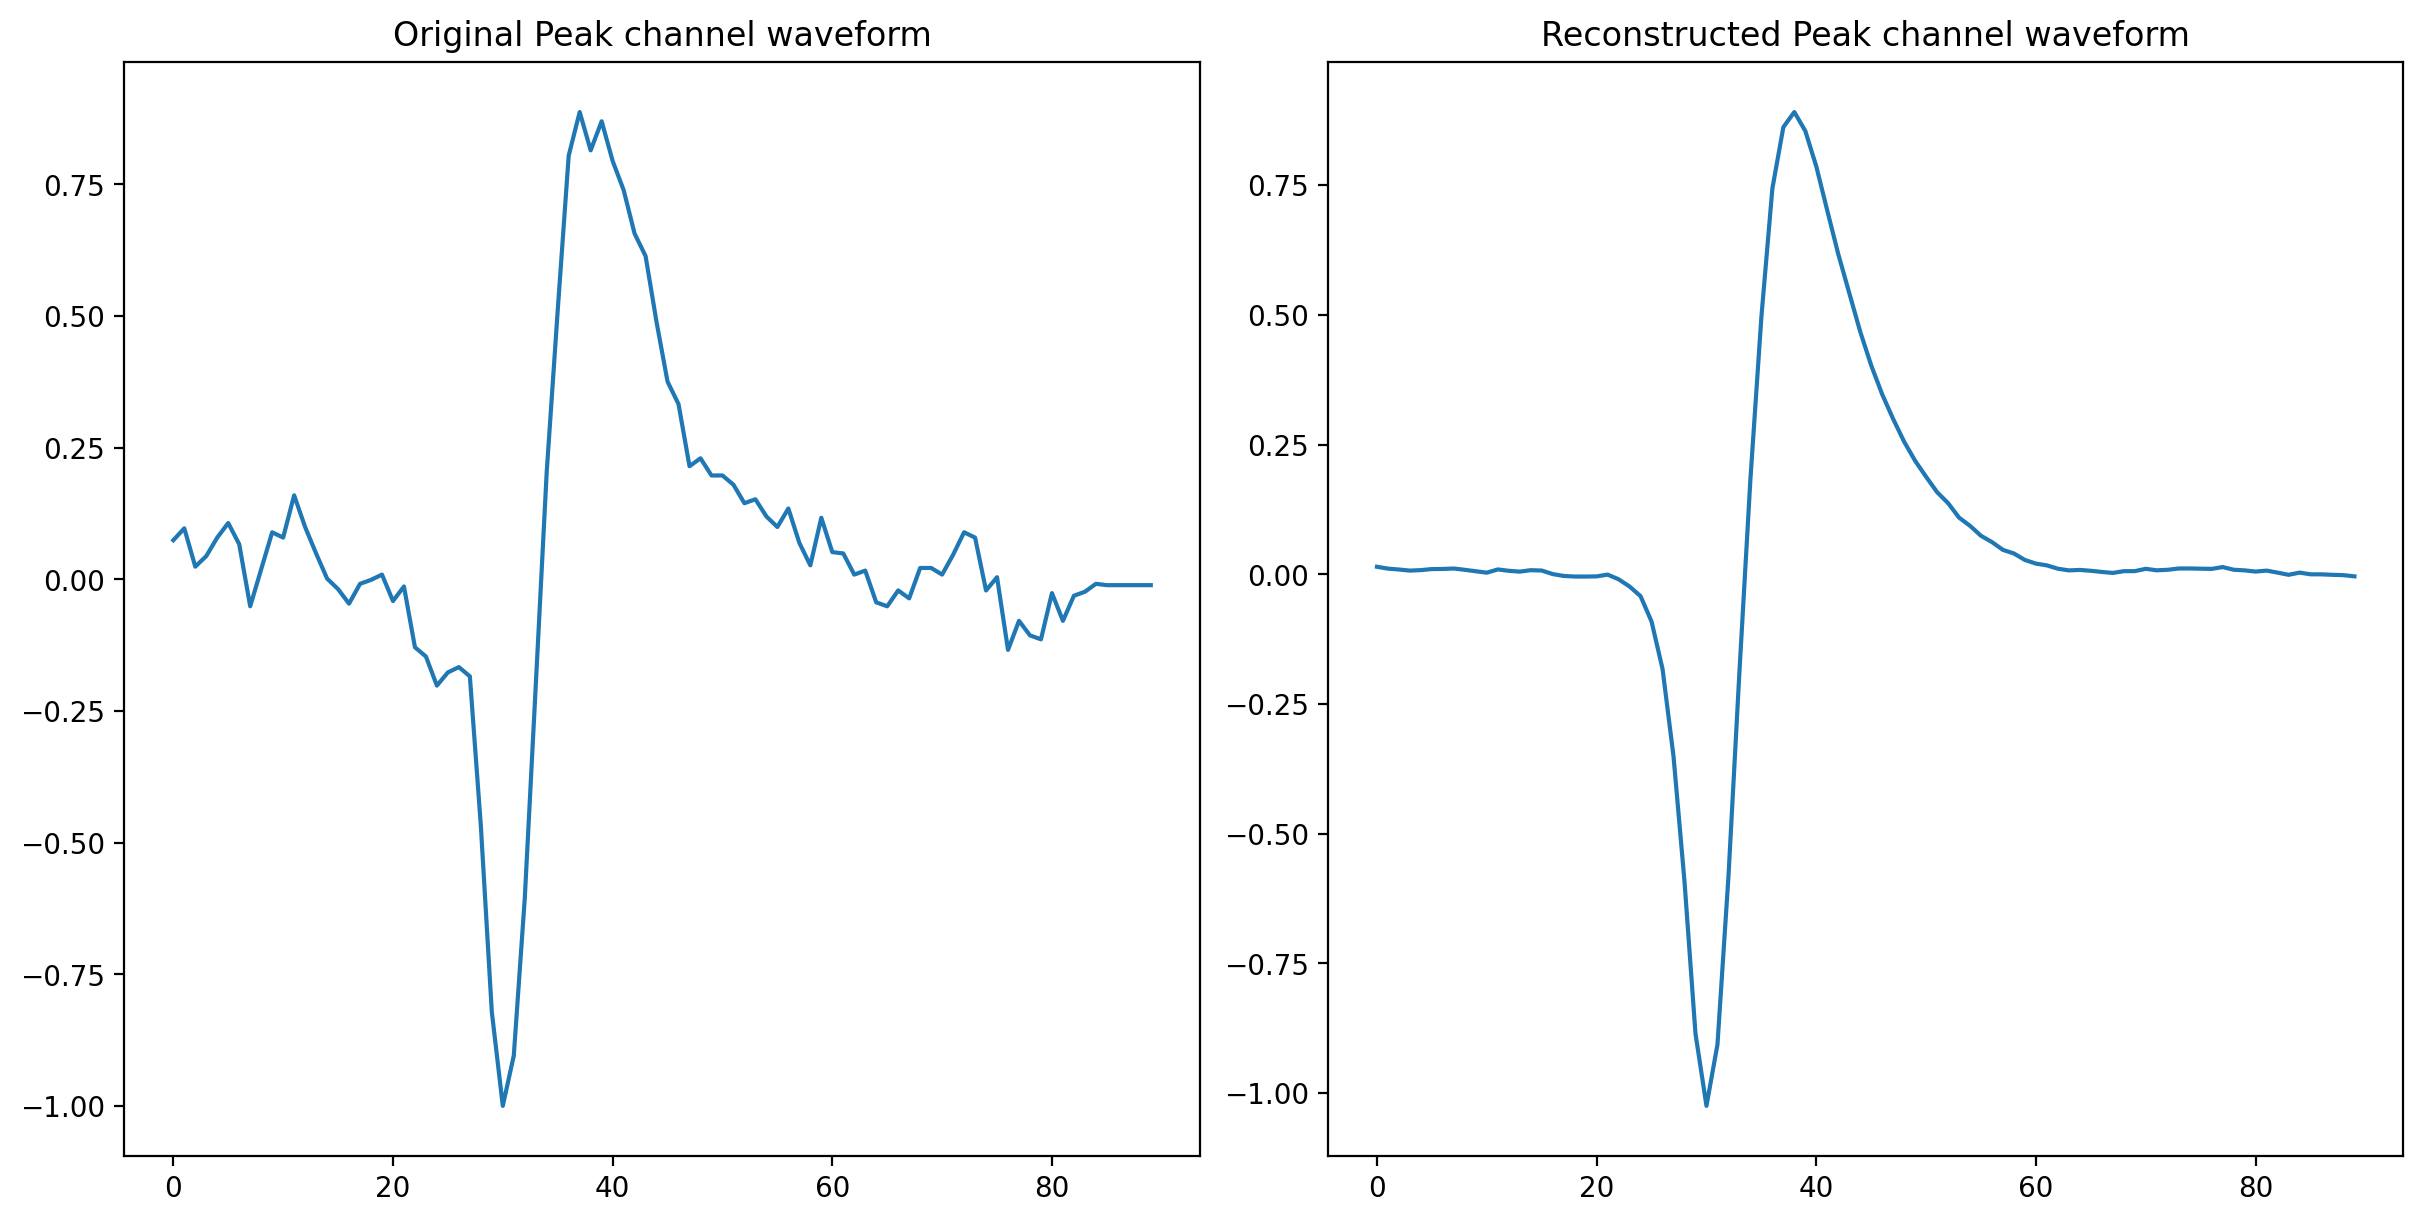

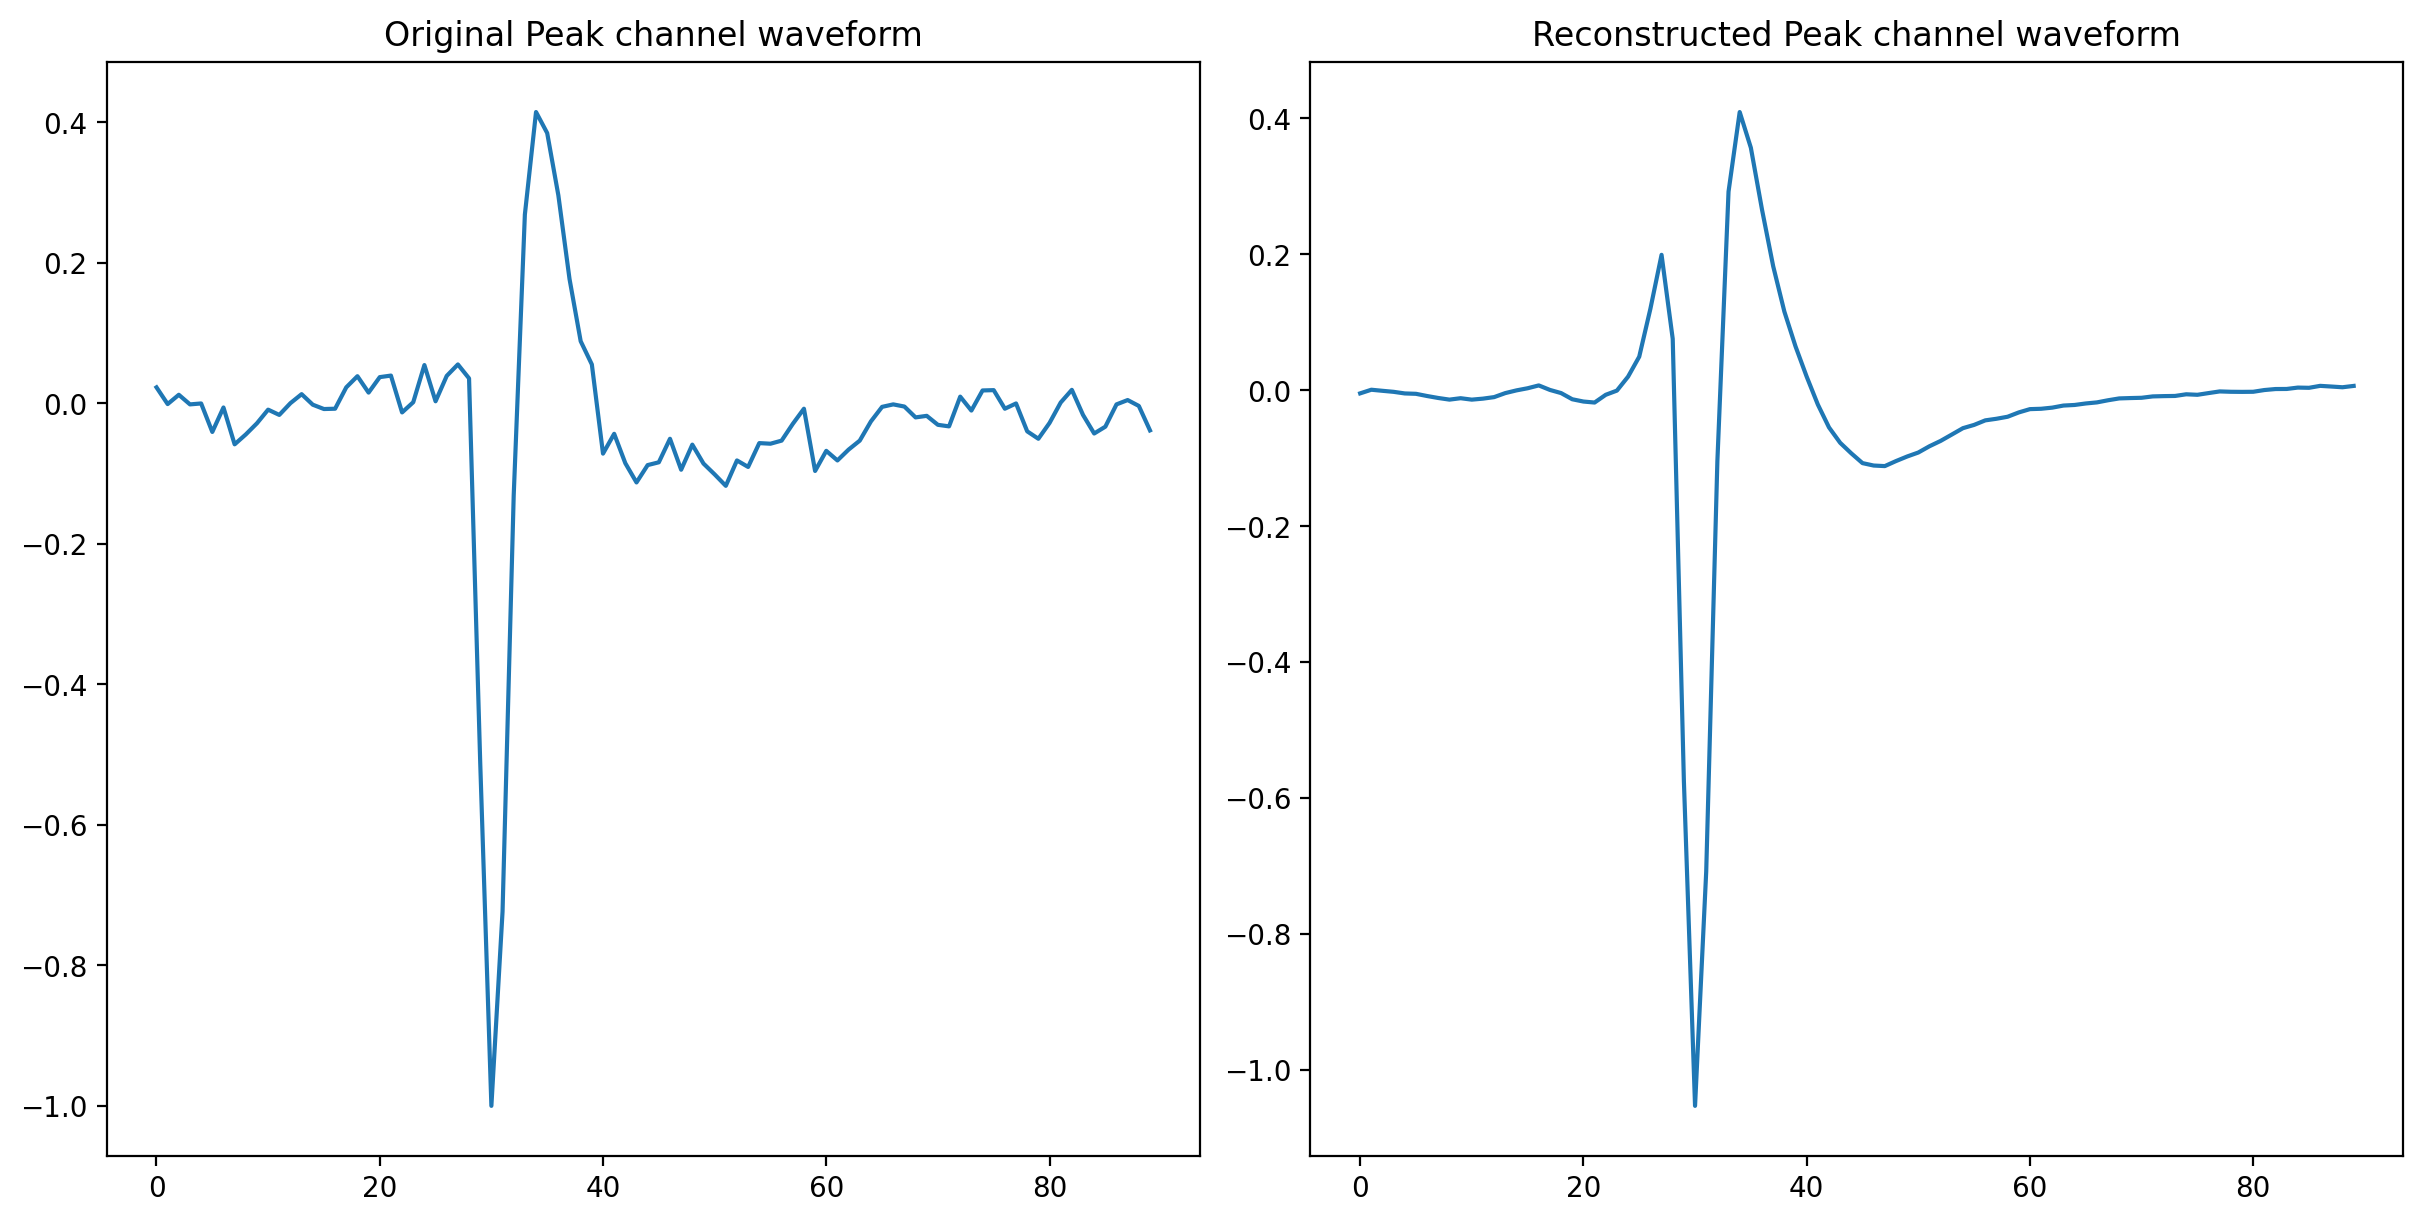

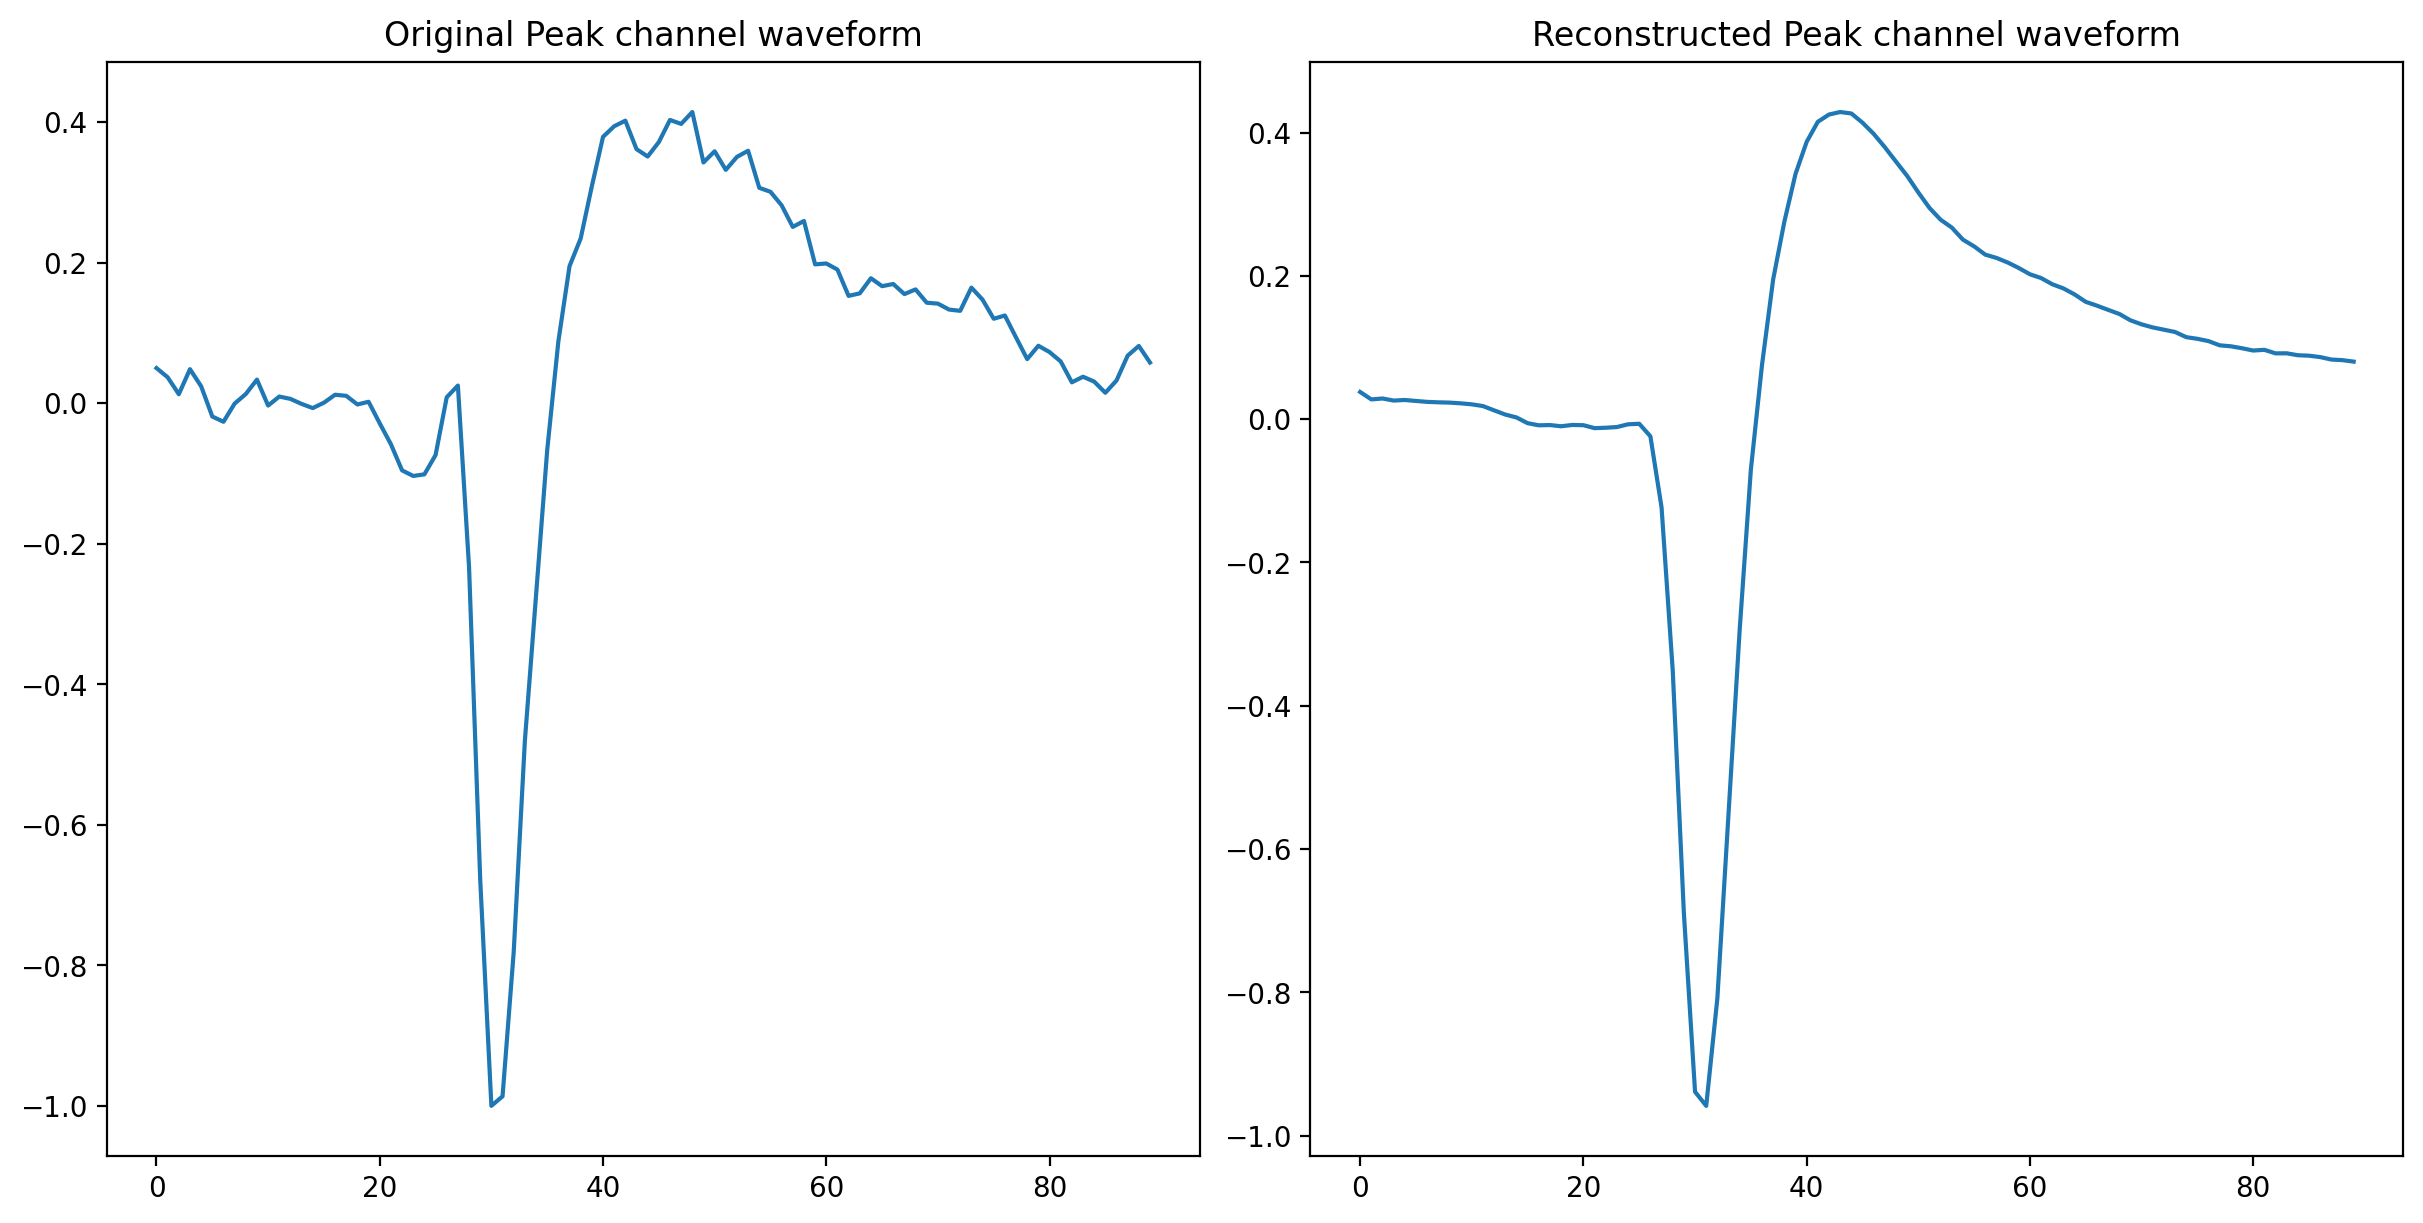

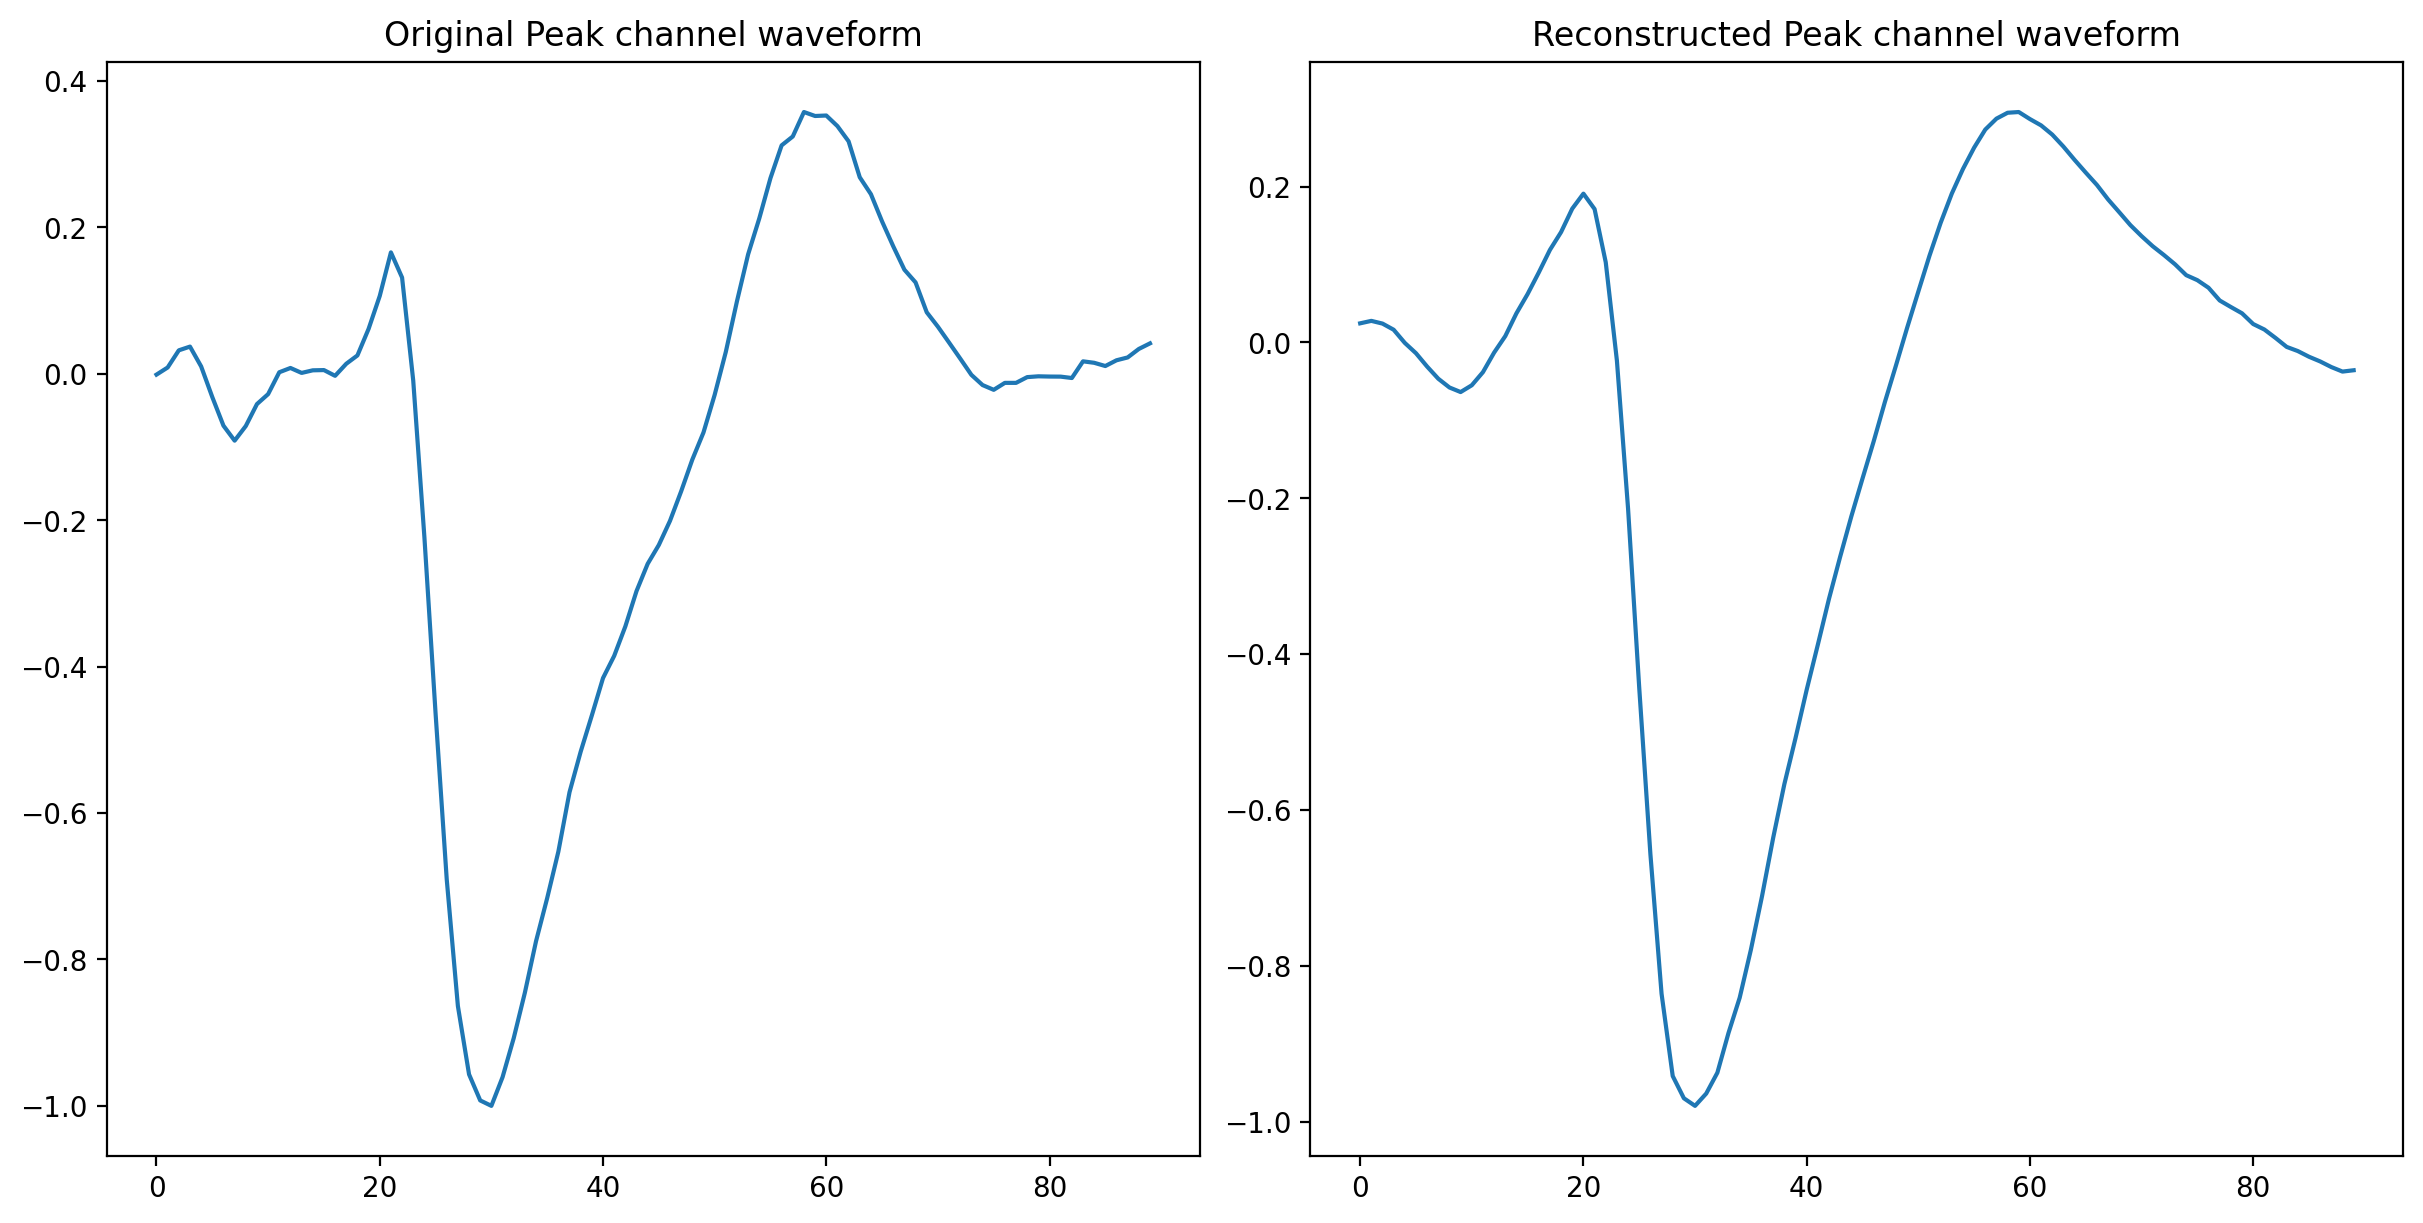

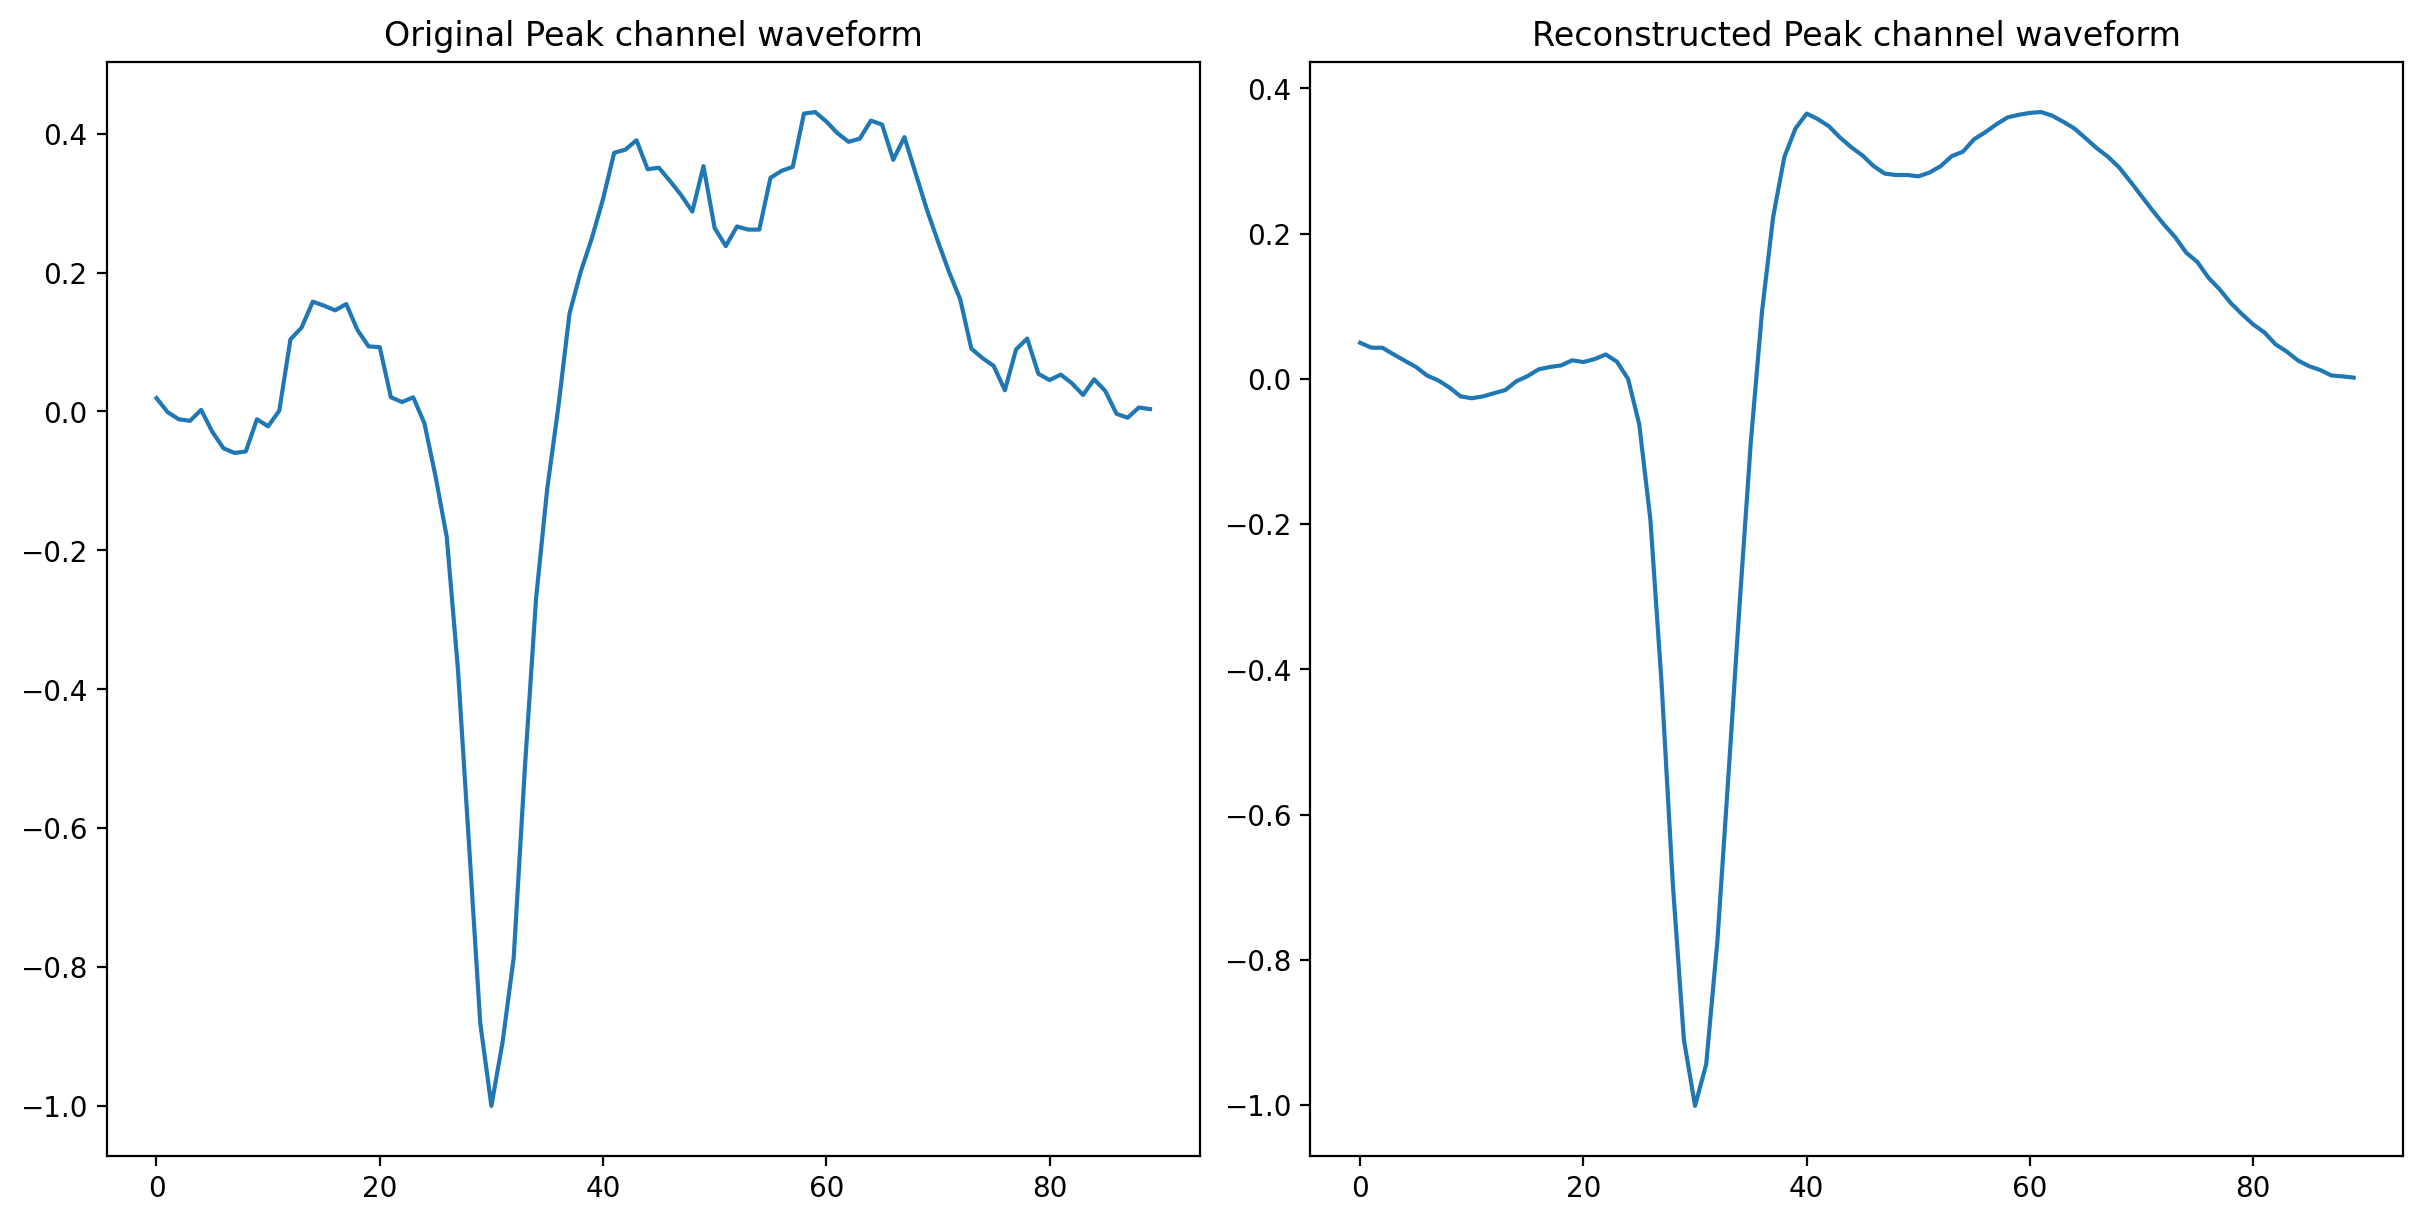

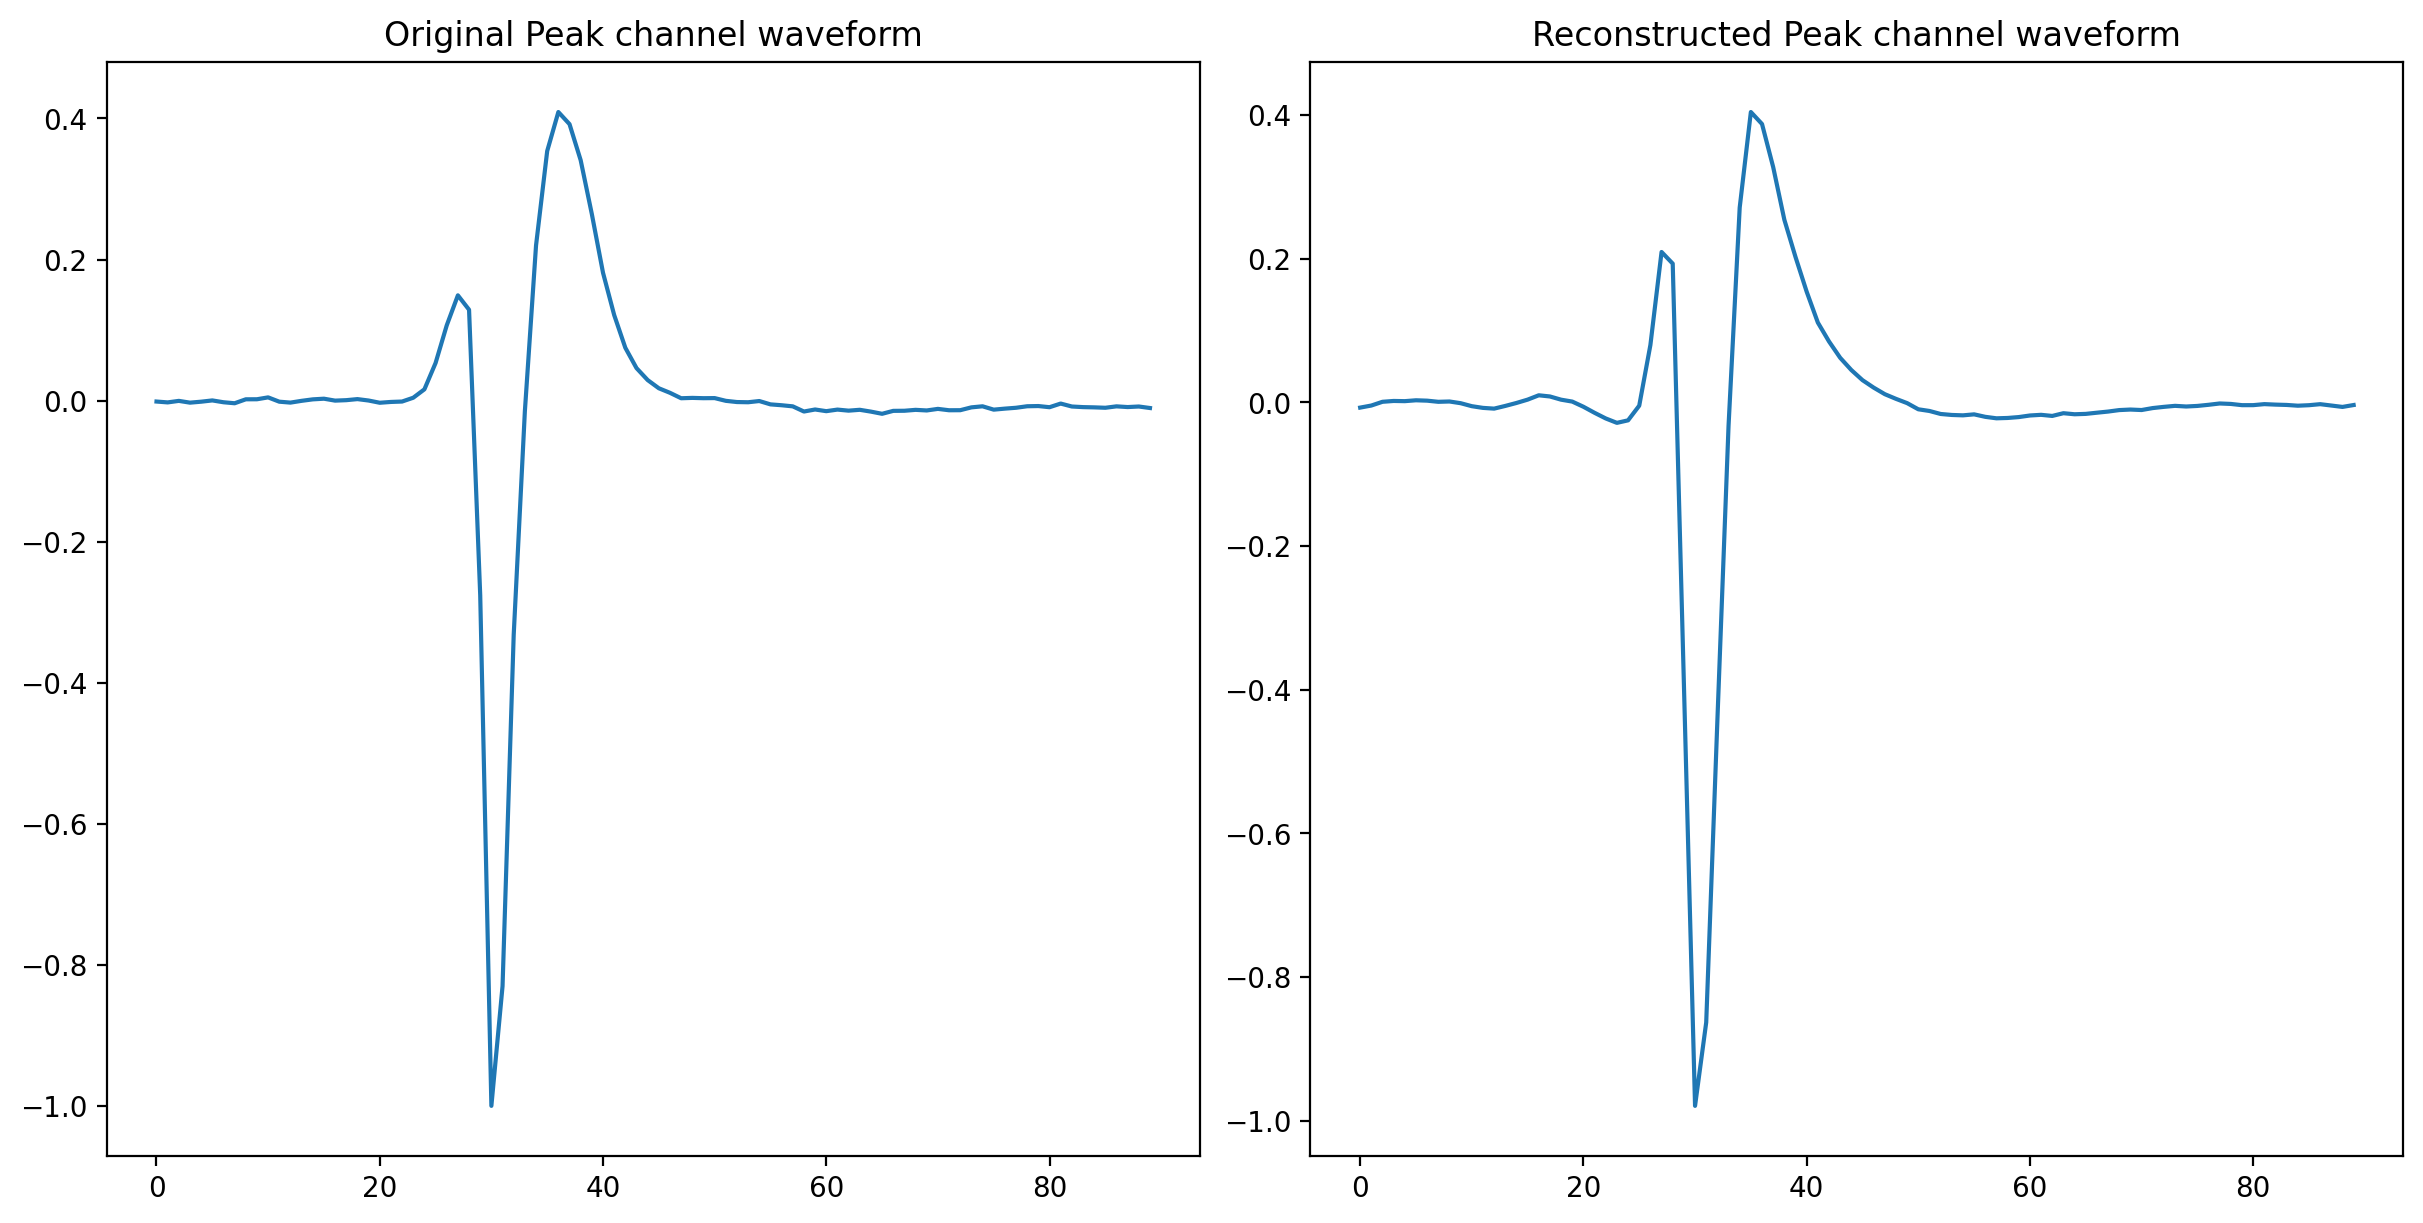

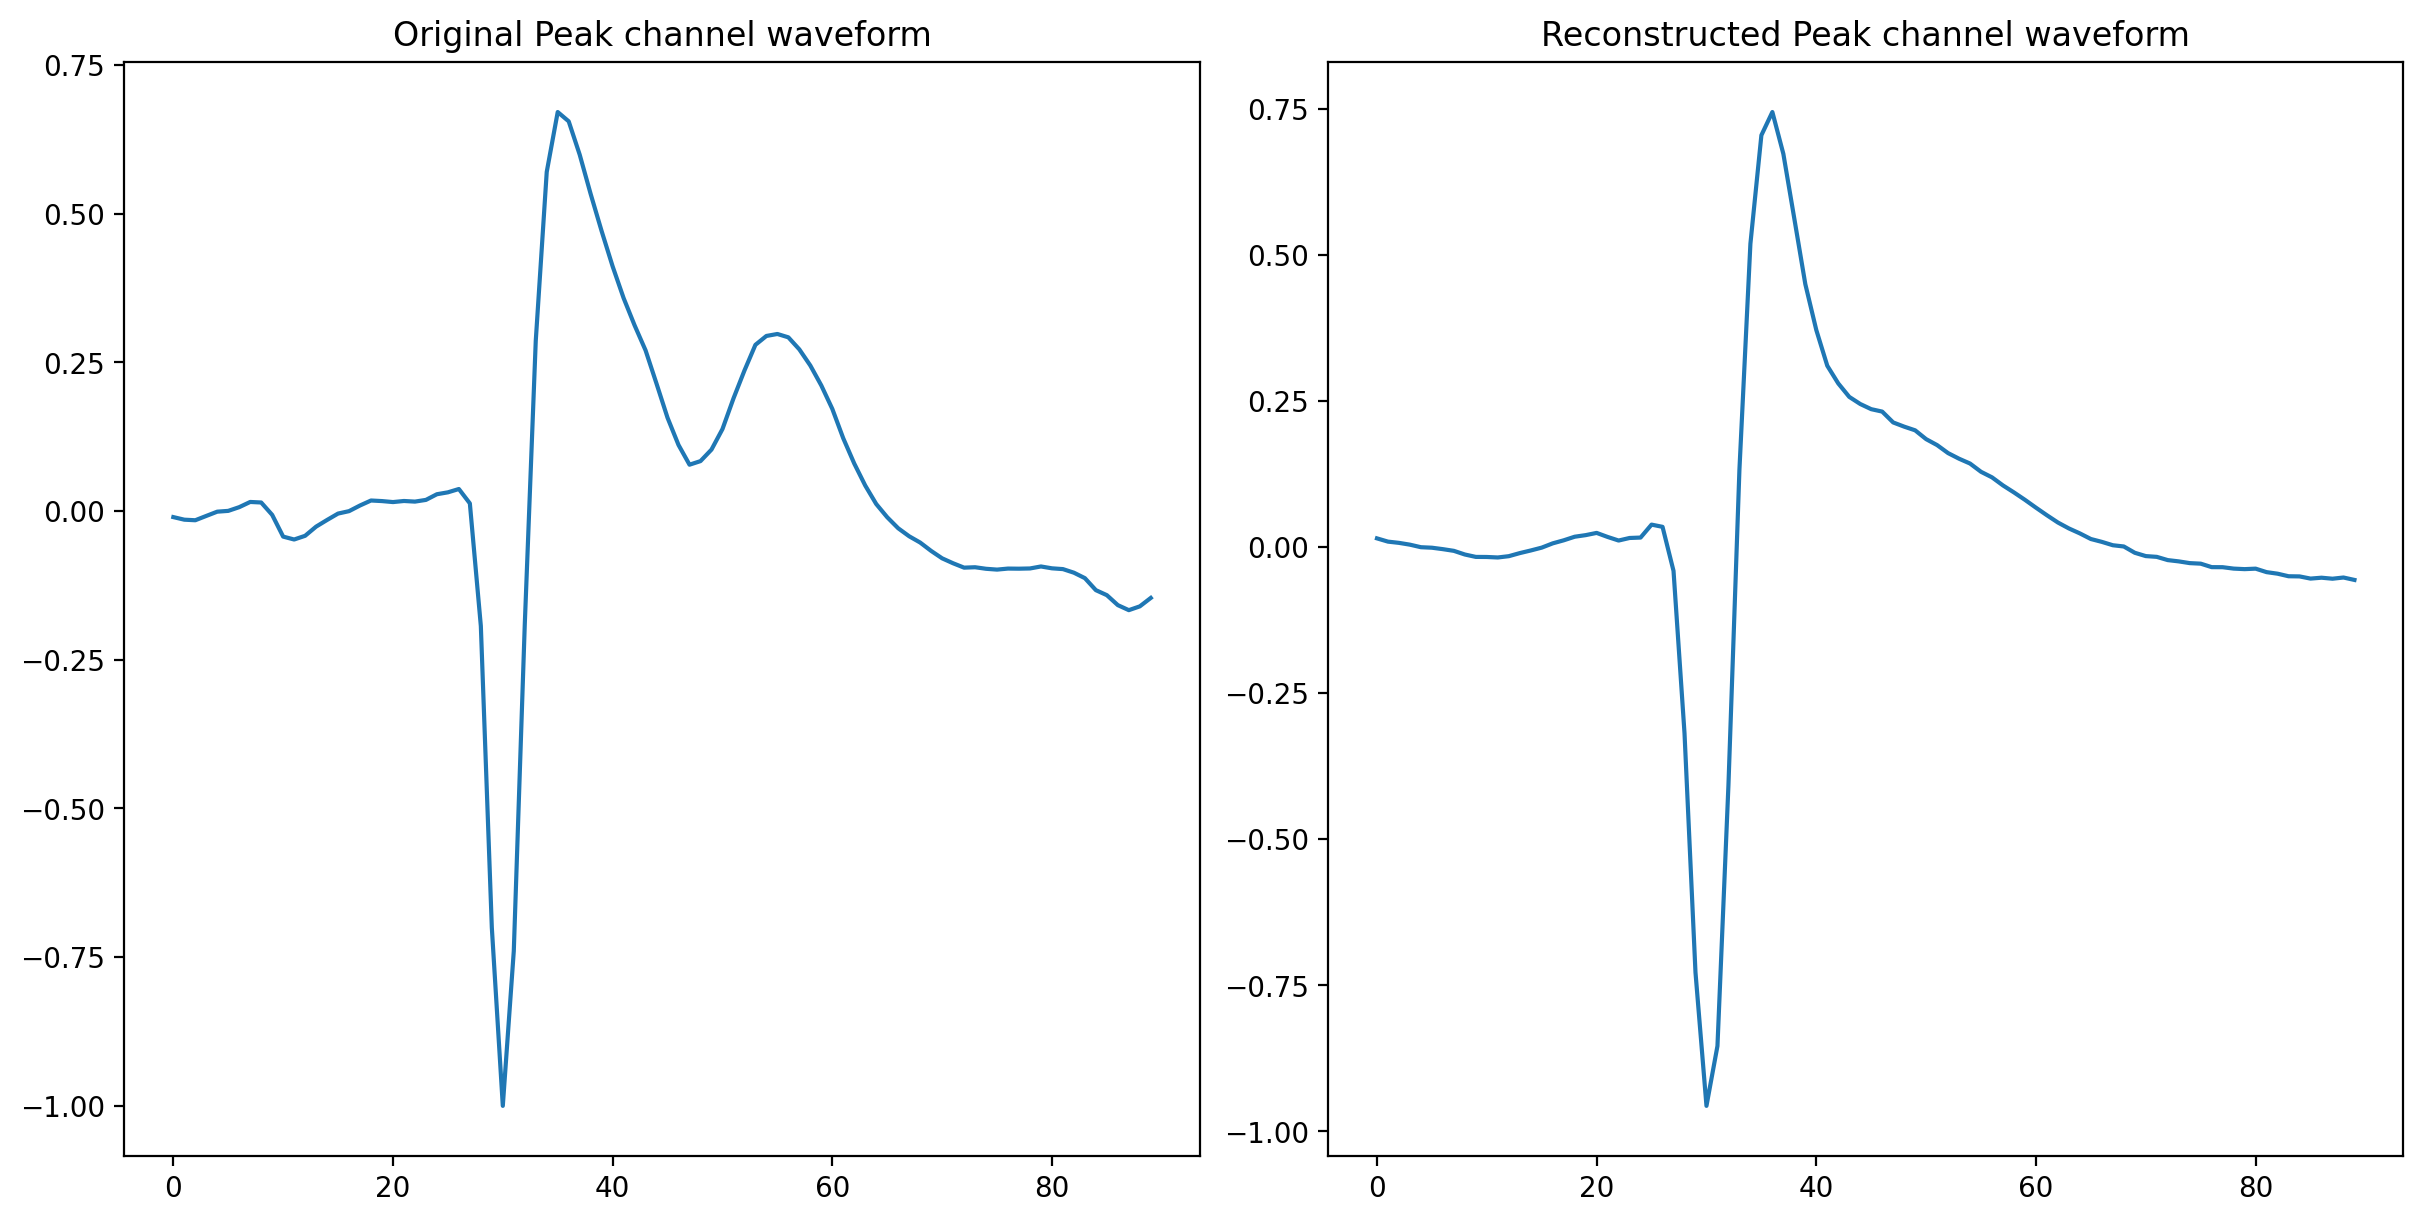

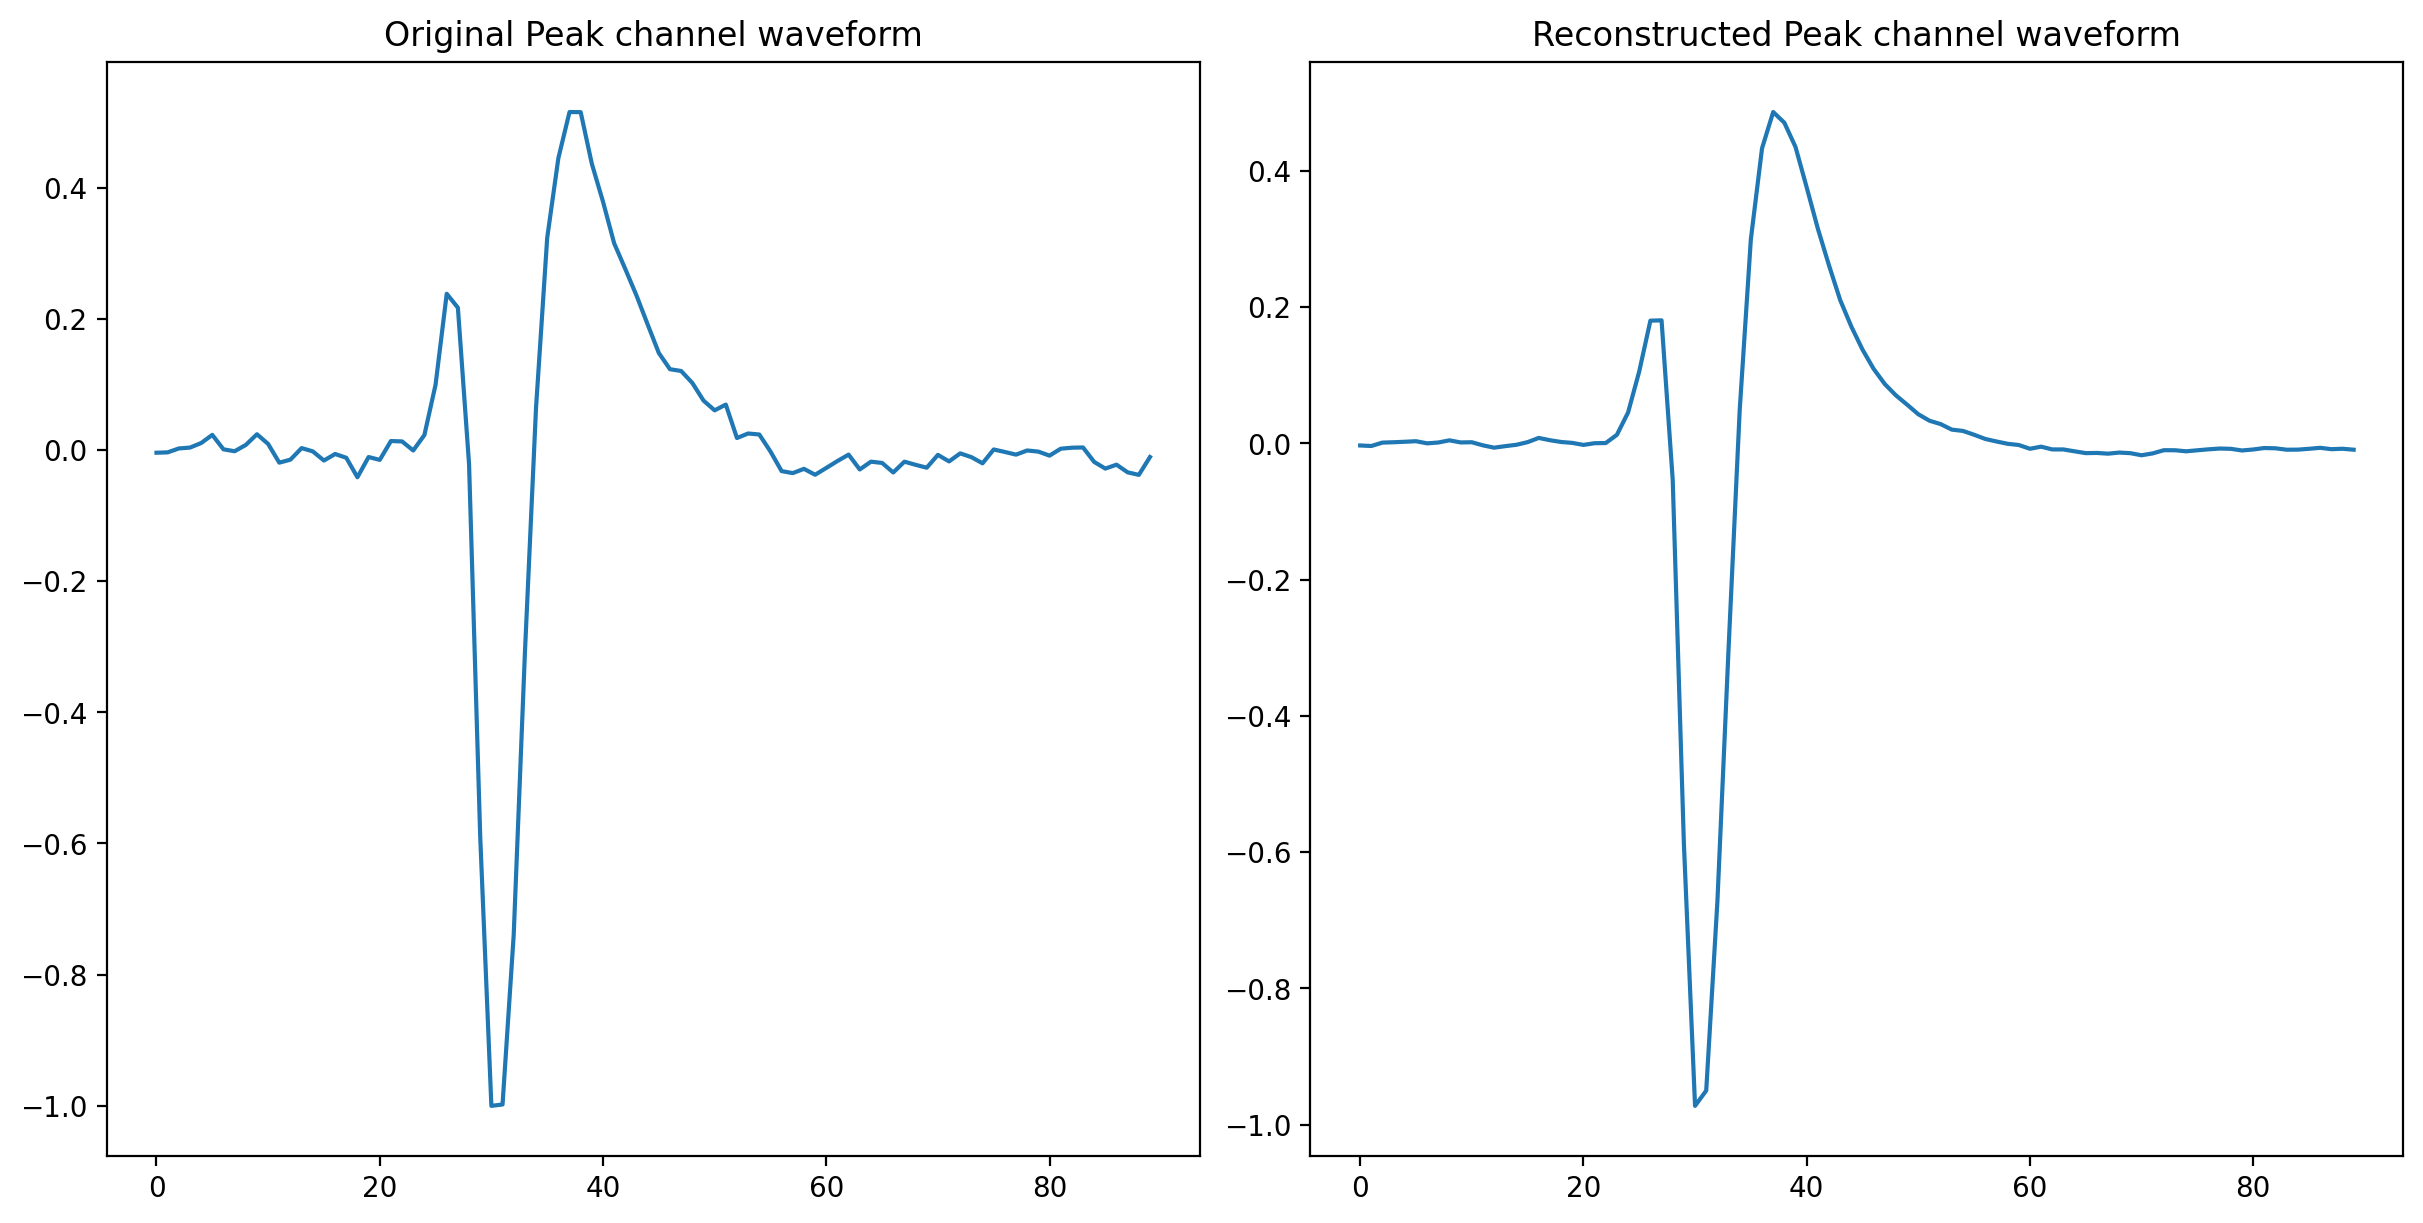

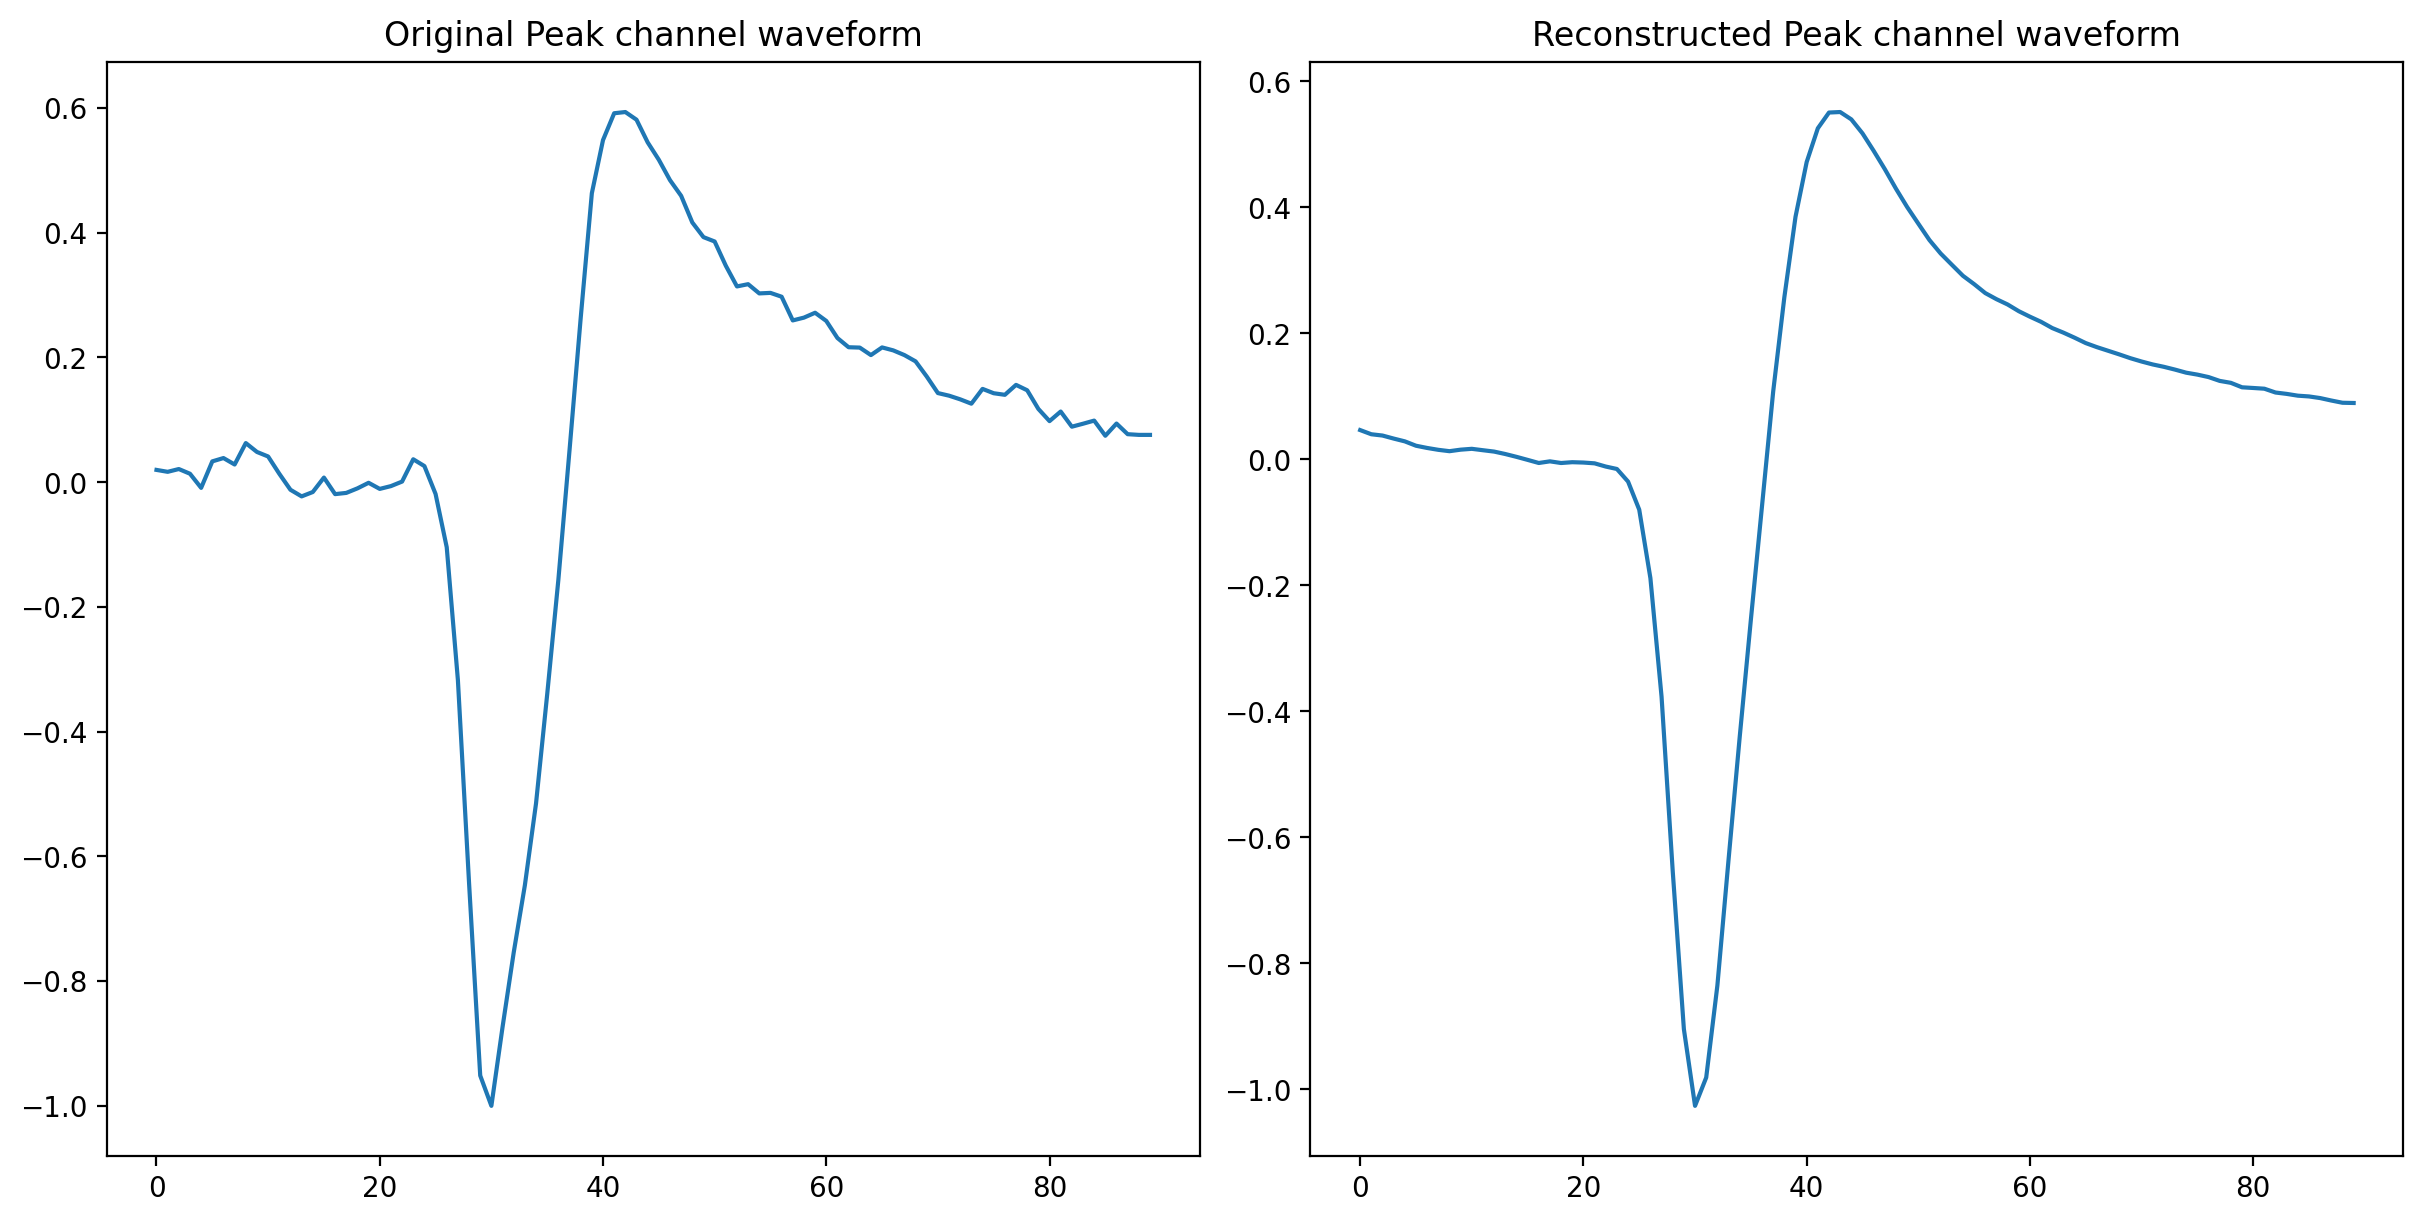

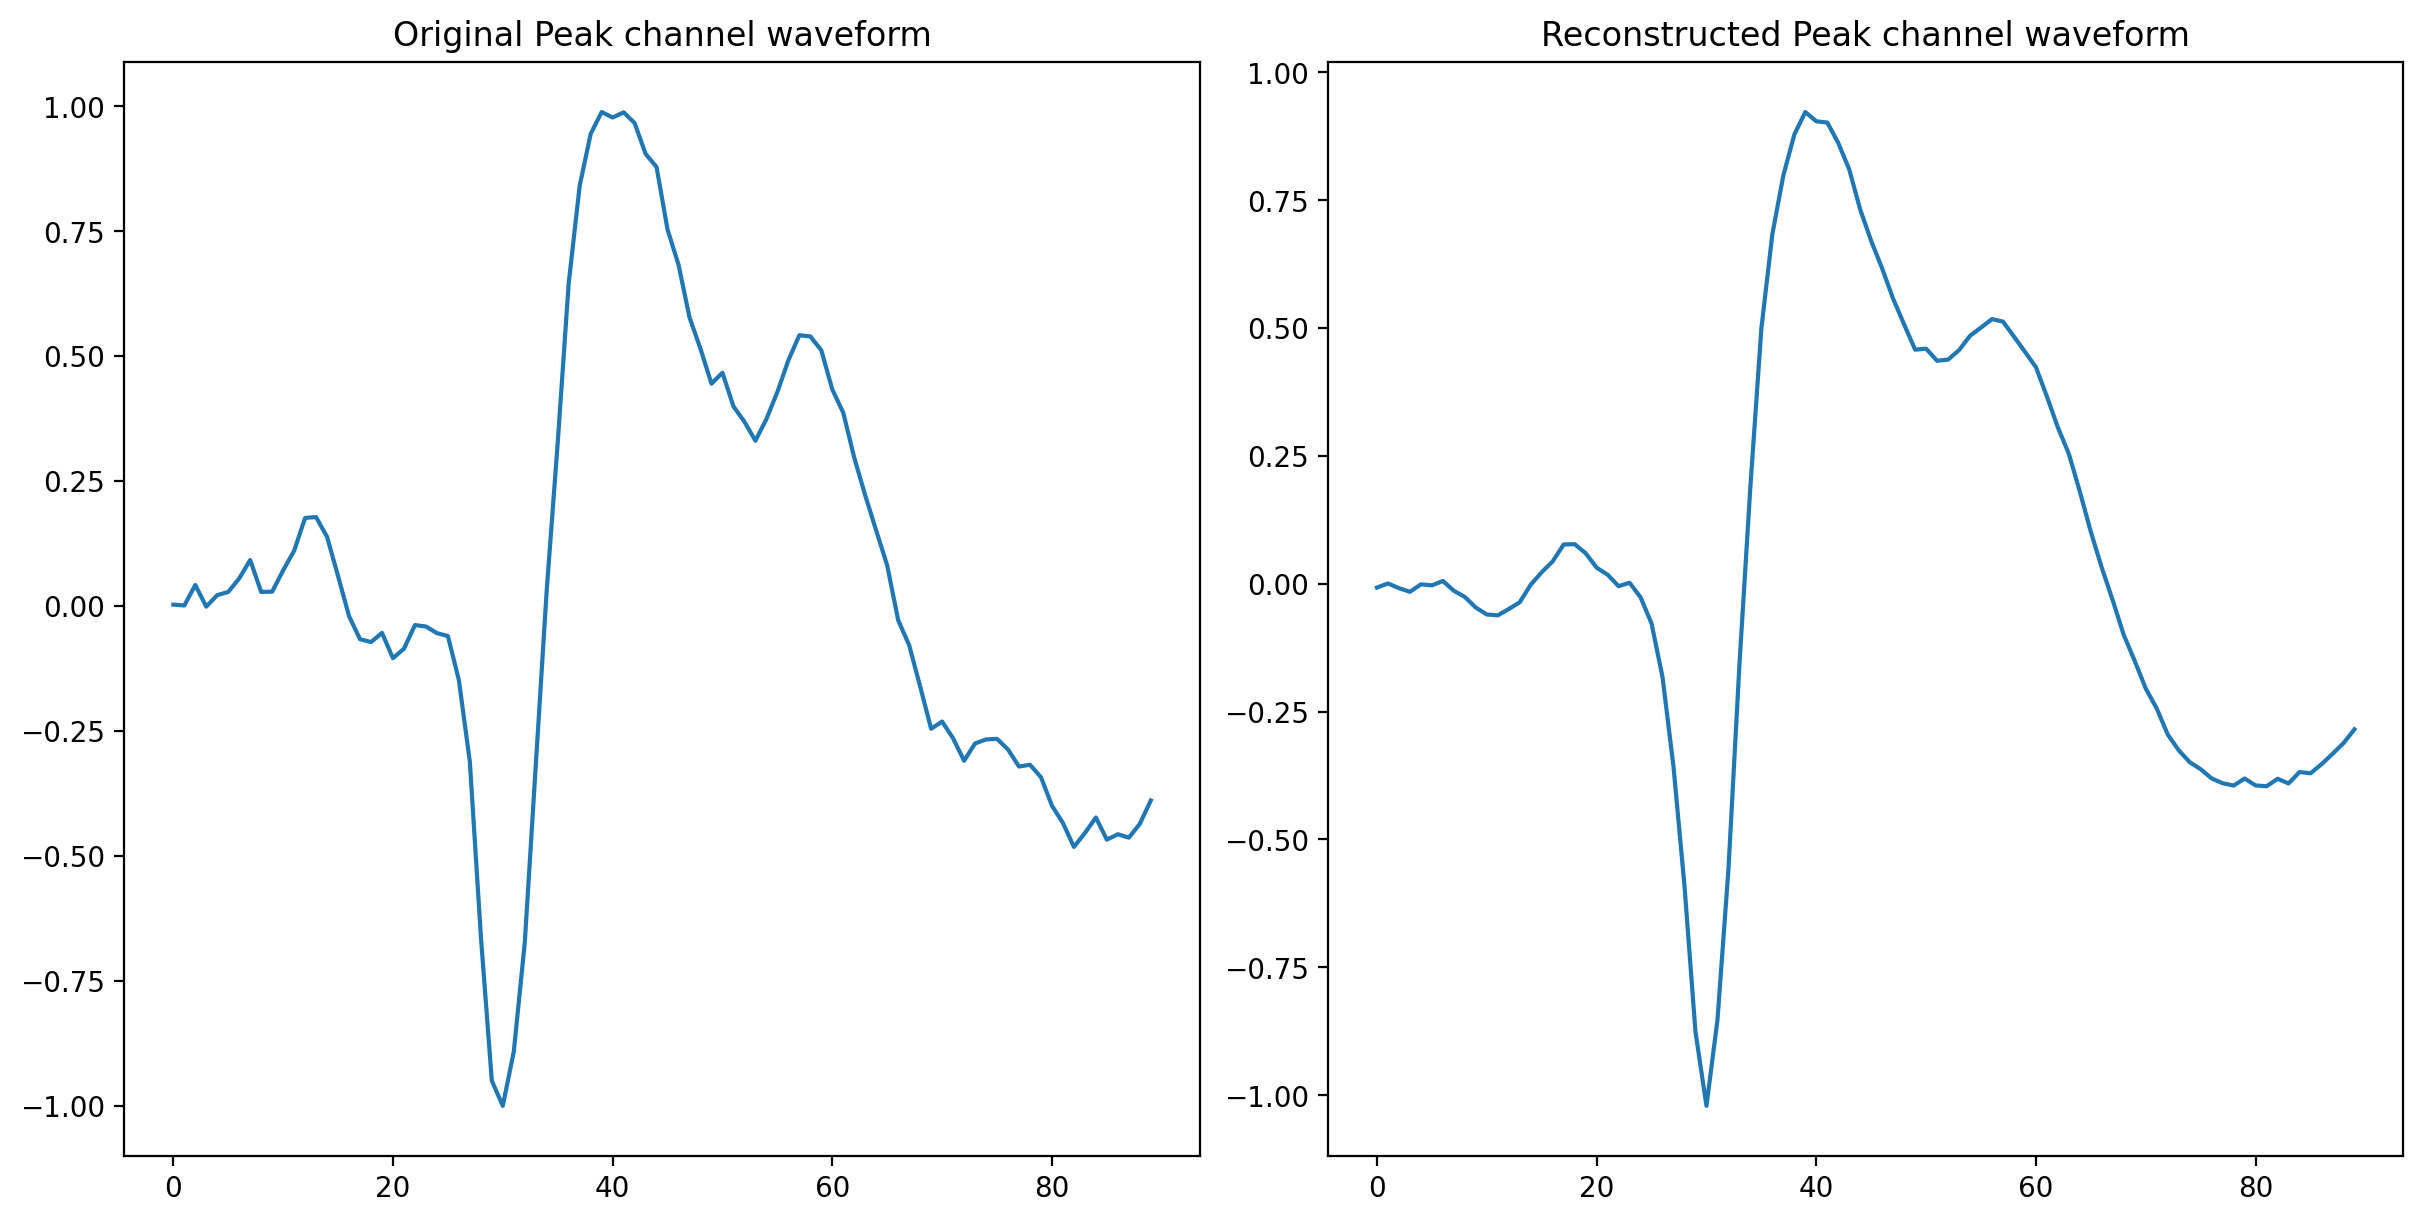

In [33]:
plot_random_reconstruction(wf_dataset, enc, dec, n_neurons=15)

In [34]:
plotting_train_loader = data.DataLoader(
    cerebellum_dataset, batch_size=len(cerebellum_dataset)
)

In [35]:
X_random_batch, y_random_batch = next(iter(plotting_train_loader))

In [36]:
import matplotlib

matplotlib.rcParams["pdf.fonttype"] = 42
matplotlib.rcParams["ps.fonttype"] = 42

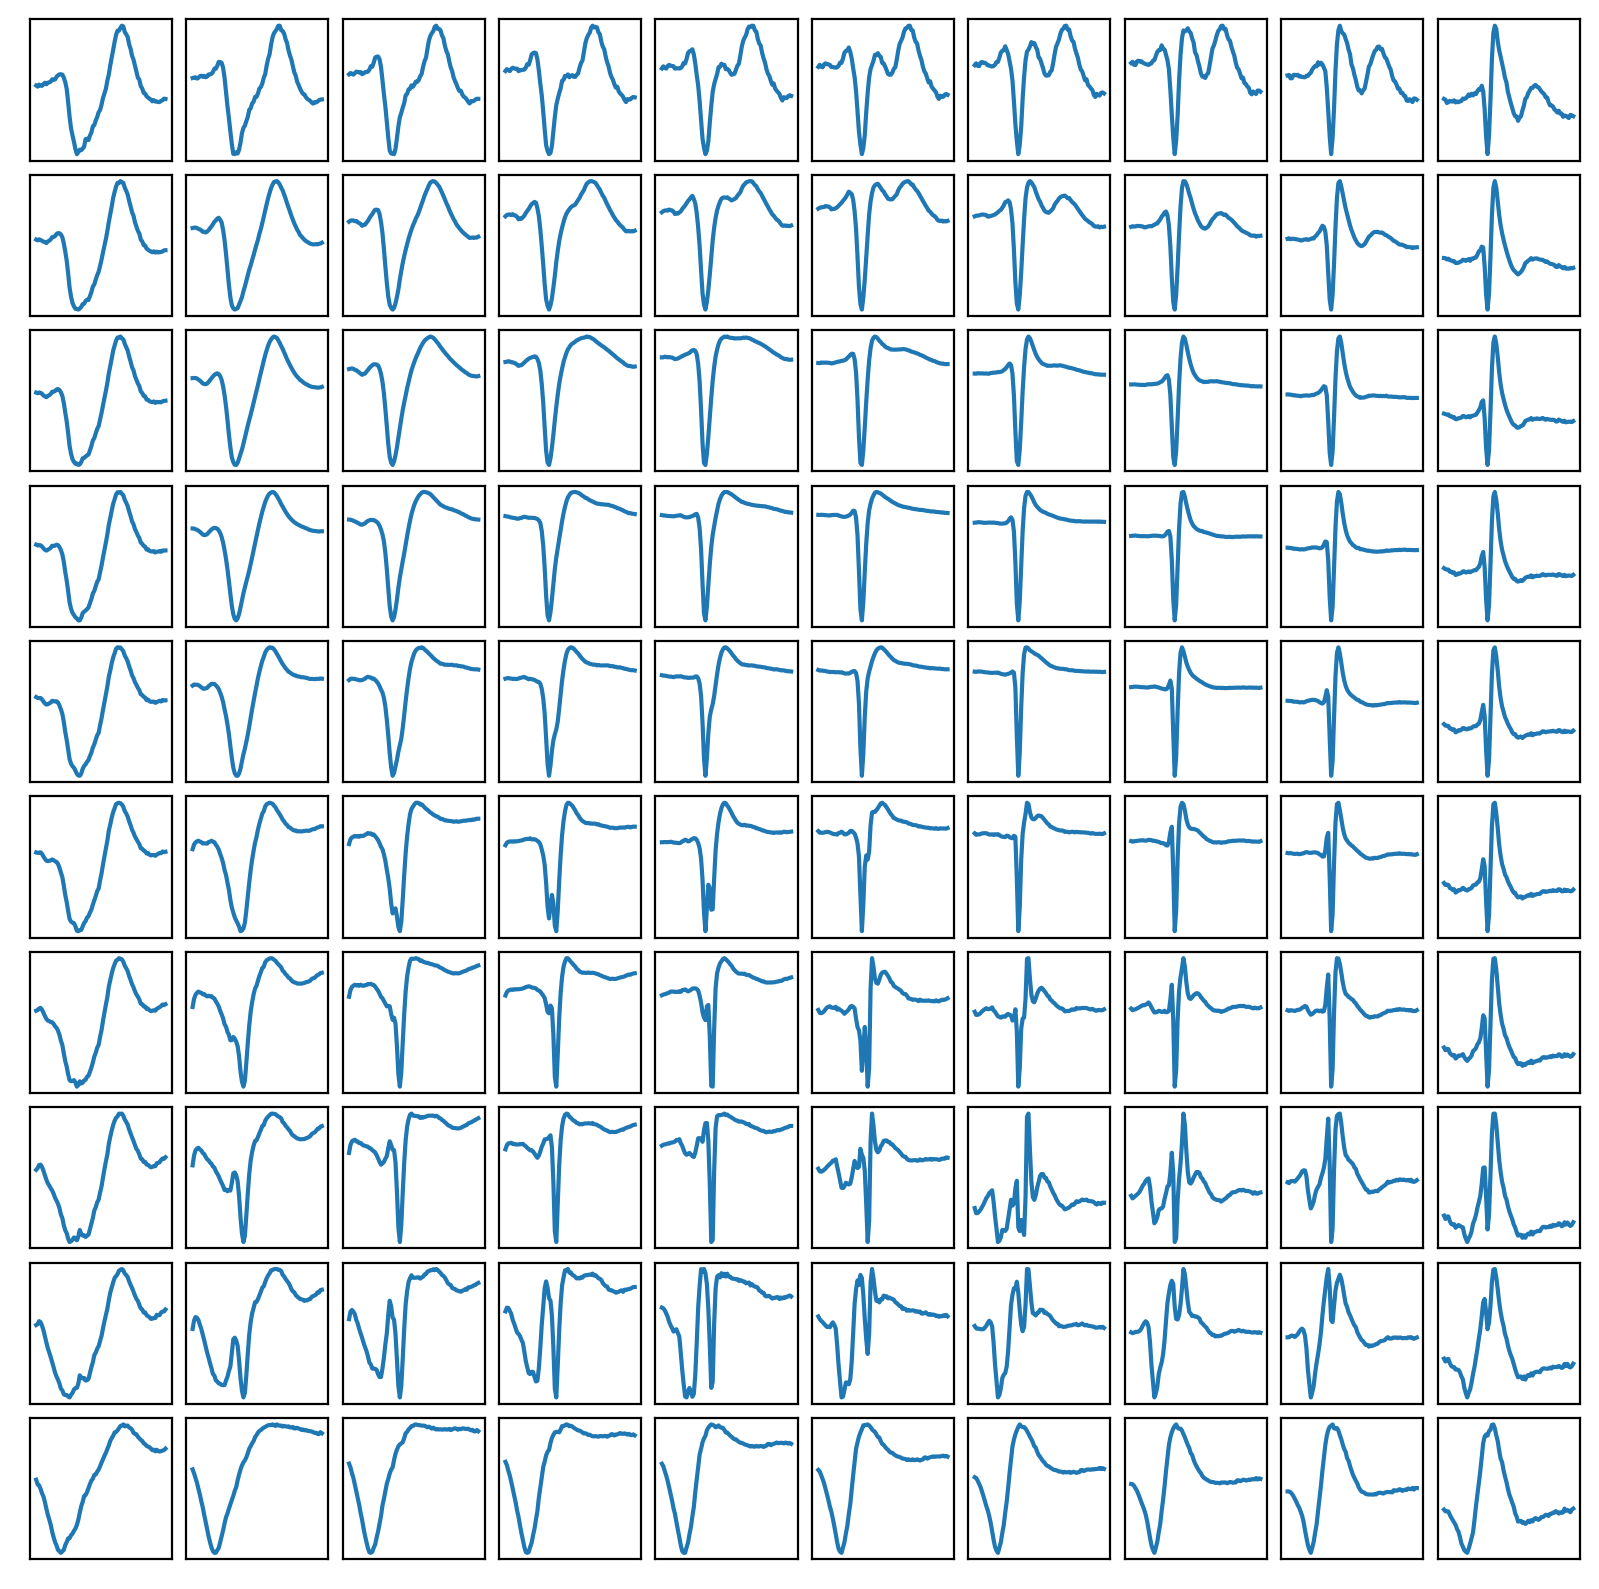

In [37]:
def plot_2d_latent(encoder, decoder, random_batch, n=15, save=False, std=1):
    """If this is a 2d latent space, it plots the latent space
    If the latent space is larger than 2d, then it plots a 2d cross-section"""
    # Take the first 2 right singular vectors from the SVD of the mean latent space vector over a random batch
    W = torch.linalg.svd(encoder(random_batch).mean).Vh[:2]
    # Take the inverse cdf of n evenly spaced points from 0 to 1
    points = dist.Normal(0, std).icdf(torch.linspace(0.01, 0.99, n))
    # Create a nxn meshgrid with the points
    XX, YY = torch.meshgrid(points, points, indexing="ij")
    # Stack the meshgrid, then reshape to 2 x xxyy. Then transpose so final is xxyy x 2
    XXYY = torch.stack((XX, YY)).reshape(2, -1).T
    # Get the decoder output of W transformed by that matrix. W is 2 x batch_size
    with torch.no_grad():
        out = decoder(XXYY @ W).numpy().squeeze()

    fig = plt.figure(figsize=(10, 10))
    gs = fig.add_gridspec(ncols=n, nrows=n, hspace=0.1, wspace=0.1)
    axs = gs.subplots()
    count = 0
    for i in range(n):
        for j in range(n):
            axs[i, j].plot(out[count, :])
            axs[i, j].set_yticks([])
            axs[i, j].set_xticks([])
            axs[i, j].label_outer()
            count += 1

    if save:
        plt.savefig(f"wvf_latent_space{n}.pdf")
    plt.show()


plot_2d_latent(enc, dec, X_random_batch, n=10, std=2, save=False)